In [1]:

import importlib
import data_prep as dp
importlib.reload(dp)
print(dir(dp))  # Check if functions appear now

/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Device set to use mps:0
Device set to use mps:0


['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'calculate_sentiment', 'calculate_sentiment_stats', 'datetime', 'download_vix_data', 'load_data', 'load_macro_df', 'macro_analysis', 'merge_dataframes', 'micro_analysis', 'np', 'pd', 'pipe', 'pipeline', 're', 'sort_by_date', 'tqdm', 'yf']


In [2]:
import matplotlib.pyplot as plt

In [3]:
df = dp.macro_analysis('./../clean_macro_5y_news_1kcap.csv', 'description', 'title')

Step 1: Loading data
Available columns in CSV: ['topic', 'title', 'description', 'source', 'published_at', 'url']
Columns after loading: ['topic', 'title', 'description', 'source', 'published_at', 'url', 'date']
Data shape after loading: (129905, 7)
Step 2: Sorting by date
Min date: 2020-04-10 00:00:00, Max date: 2025-04-10 00:00:00
Columns after sorting: ['topic', 'title', 'description', 'source', 'published_at', 'url', 'date']
Step 3: Calculating summary sentiment
Analyzing sentiment for 129905 entries in column 'description'...


Sentiment analysis for 'description':   0%|          | 34/129905 [00:01<1:28:33, 24.44it/s]

Error processing text: The size of tensor a (559) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3989, Clean length: 3989, Truncated length: 2487
Error processing text: The size of tensor a (552) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3114, Clean length: 3114, Truncated length: 2495


Sentiment analysis for 'description':   0%|          | 52/129905 [00:02<56:20, 38.42it/s]  

Error processing text: The size of tensor a (545) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 14985, Clean length: 14985, Truncated length: 2613
Error processing text: The size of tensor a (545) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 14985, Clean length: 14985, Truncated length: 2613
Error processing text: The size of tensor a (522) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 12518, Clean length: 12518, Truncated length: 2640
Error processing text: The size of tensor a (522) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 12518, Clean length: 12518, Truncated length: 2640
Error processing text: The size of tensor a (553) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 15936, Clean length: 15936, Truncated length: 2587
Error processing text: The size of tensor a (594) must match the size of te

Sentiment analysis for 'description':   0%|          | 57/129905 [00:02<55:54, 38.70it/s]

Error processing text: The size of tensor a (529) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 14780, Clean length: 14780, Truncated length: 2449


Sentiment analysis for 'description':   0%|          | 66/129905 [00:02<1:11:30, 30.26it/s]

Error processing text: The size of tensor a (514) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 10117, Clean length: 10117, Truncated length: 2358
Error processing text: The size of tensor a (568) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6941, Clean length: 6941, Truncated length: 2500


Sentiment analysis for 'description':   0%|          | 79/129905 [00:02<1:00:46, 35.60it/s]

Error processing text: The size of tensor a (600) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 12062, Clean length: 12062, Truncated length: 2436
Error processing text: The size of tensor a (600) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 12062, Clean length: 12062, Truncated length: 2436


Sentiment analysis for 'description':   0%|          | 88/129905 [00:03<1:03:22, 34.14it/s]

Error processing text: The size of tensor a (538) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5758, Clean length: 5758, Truncated length: 2722
Error processing text: The size of tensor a (682) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4105, Clean length: 4105, Truncated length: 2846
Error processing text: The size of tensor a (576) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 7451, Clean length: 7451, Truncated length: 2593
Error processing text: The size of tensor a (518) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6070, Clean length: 6070, Truncated length: 2409


Sentiment analysis for 'description':   0%|          | 105/129905 [00:03<1:05:17, 33.13it/s]

Error processing text: The size of tensor a (522) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6890, Clean length: 6890, Truncated length: 2505
Error processing text: The size of tensor a (522) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6890, Clean length: 6890, Truncated length: 2505


Sentiment analysis for 'description':   0%|          | 137/129905 [00:04<49:21, 43.82it/s]  

Error processing text: The size of tensor a (516) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2294, Clean length: 2294, Truncated length: 2294
Error processing text: The size of tensor a (516) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2294, Clean length: 2294, Truncated length: 2294
Error processing text: The size of tensor a (514) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 8881, Clean length: 8881, Truncated length: 2403
Error processing text: The size of tensor a (617) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3684, Clean length: 3684, Truncated length: 2657


Sentiment analysis for 'description':   0%|          | 142/129905 [00:04<51:00, 42.39it/s]

Error processing text: The size of tensor a (519) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 14287, Clean length: 14287, Truncated length: 2643


Sentiment analysis for 'description':   0%|          | 163/129905 [00:05<45:54, 47.10it/s]  

Error processing text: The size of tensor a (519) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 14287, Clean length: 14287, Truncated length: 2643
Error processing text: The size of tensor a (596) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2073, Clean length: 2073, Truncated length: 2073


Sentiment analysis for 'description':   0%|          | 179/129905 [00:05<53:53, 40.12it/s]

Error processing text: The size of tensor a (541) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 7791, Clean length: 7791, Truncated length: 2277


Sentiment analysis for 'description':   0%|          | 203/129905 [00:06<1:03:35, 34.00it/s]

Error processing text: The size of tensor a (552) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2914, Clean length: 2914, Truncated length: 2405
Error processing text: The size of tensor a (561) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6830, Clean length: 6830, Truncated length: 2493


Sentiment analysis for 'description':   0%|          | 214/129905 [00:06<51:32, 41.93it/s]  

Error processing text: The size of tensor a (514) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 8881, Clean length: 8881, Truncated length: 2403
Error processing text: The size of tensor a (577) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 12791, Clean length: 12791, Truncated length: 2513
Error processing text: The size of tensor a (527) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 7733, Clean length: 7733, Truncated length: 2595


Sentiment analysis for 'description':   0%|          | 262/129905 [00:07<26:34, 81.33it/s]

Error processing text: The size of tensor a (530) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4108, Clean length: 4108, Truncated length: 2393
Error processing text: The size of tensor a (585) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 9163, Clean length: 9163, Truncated length: 2676
Error processing text: The size of tensor a (515) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3277, Clean length: 3277, Truncated length: 2555


Sentiment analysis for 'description':   0%|          | 290/129905 [00:07<31:18, 69.00it/s]

Error processing text: The size of tensor a (585) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 9163, Clean length: 9163, Truncated length: 2676
Error processing text: The size of tensor a (522) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5264, Clean length: 5264, Truncated length: 2320


Sentiment analysis for 'description':   0%|          | 305/129905 [00:08<40:57, 52.74it/s]

Error processing text: The size of tensor a (536) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3631, Clean length: 3631, Truncated length: 2444


Sentiment analysis for 'description':   0%|          | 318/129905 [00:08<49:05, 44.00it/s]

Error processing text: The size of tensor a (535) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4529, Clean length: 4529, Truncated length: 2461
Error processing text: The size of tensor a (541) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 8290, Clean length: 8290, Truncated length: 2398


Sentiment analysis for 'description':   0%|          | 335/129905 [00:08<50:38, 42.64it/s]

Error processing text: The size of tensor a (536) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3631, Clean length: 3631, Truncated length: 2444
Error processing text: The size of tensor a (541) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5500, Clean length: 5500, Truncated length: 2675


Sentiment analysis for 'description':   0%|          | 358/129905 [00:09<47:43, 45.24it/s]

Error processing text: The size of tensor a (567) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 8710, Clean length: 8710, Truncated length: 2427


Sentiment analysis for 'description':   0%|          | 374/129905 [00:09<55:00, 39.24it/s]

Error processing text: The size of tensor a (523) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 9476, Clean length: 9476, Truncated length: 2366


Sentiment analysis for 'description':   0%|          | 383/129905 [00:10<1:07:29, 31.98it/s]

Error processing text: The size of tensor a (786) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2522, Clean length: 2522, Truncated length: 2522
Error processing text: The size of tensor a (604) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4483, Clean length: 4483, Truncated length: 2685


Sentiment analysis for 'description':   0%|          | 393/129905 [00:10<1:02:28, 34.55it/s]

Error processing text: The size of tensor a (786) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2522, Clean length: 2522, Truncated length: 2522
Error processing text: The size of tensor a (786) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2522, Clean length: 2522, Truncated length: 2522


Sentiment analysis for 'description':   0%|          | 551/129905 [00:13<58:25, 36.90it/s]  

Error processing text: The size of tensor a (533) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6343, Clean length: 6343, Truncated length: 2521


Sentiment analysis for 'description':   1%|          | 650/129905 [00:15<41:24, 52.02it/s]  

Error processing text: The size of tensor a (548) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5976, Clean length: 5976, Truncated length: 2513
Error processing text: The size of tensor a (541) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4996, Clean length: 4996, Truncated length: 2388


Sentiment analysis for 'description':   1%|          | 685/129905 [00:16<48:24, 44.48it/s]

Error processing text: The size of tensor a (579) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 10358, Clean length: 10358, Truncated length: 2660
Error processing text: The size of tensor a (661) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5198, Clean length: 5198, Truncated length: 2563
Error processing text: The size of tensor a (646) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 12005, Clean length: 12005, Truncated length: 2814
Error processing text: The size of tensor a (646) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 12005, Clean length: 12005, Truncated length: 2814


Sentiment analysis for 'description':   1%|          | 723/129905 [00:17<41:37, 51.72it/s]

Error processing text: The size of tensor a (513) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 7011, Clean length: 7011, Truncated length: 2515
Error processing text: The size of tensor a (547) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 8538, Clean length: 8538, Truncated length: 2384


Sentiment analysis for 'description':   1%|          | 743/129905 [00:17<34:54, 61.68it/s]

Error processing text: The size of tensor a (547) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 8538, Clean length: 8538, Truncated length: 2384
Error processing text: The size of tensor a (547) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 8538, Clean length: 8538, Truncated length: 2384
Error processing text: The size of tensor a (547) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 8538, Clean length: 8538, Truncated length: 2384


Sentiment analysis for 'description':   1%|          | 757/129905 [00:17<35:55, 59.93it/s]

Error processing text: The size of tensor a (547) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 8501, Clean length: 8501, Truncated length: 2380


Sentiment analysis for 'description':   1%|          | 804/129905 [00:18<35:39, 60.34it/s]

Error processing text: The size of tensor a (661) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5198, Clean length: 5198, Truncated length: 2563


Sentiment analysis for 'description':   1%|          | 828/129905 [00:19<46:22, 46.39it/s]

Error processing text: The size of tensor a (533) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2384, Clean length: 2384, Truncated length: 2384
Error processing text: The size of tensor a (533) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2384, Clean length: 2384, Truncated length: 2384
Error processing text: The size of tensor a (533) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2384, Clean length: 2384, Truncated length: 2384
Error processing text: The size of tensor a (533) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2384, Clean length: 2384, Truncated length: 2384
Error processing text: The size of tensor a (533) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2384, Clean length: 2384, Truncated length: 2384
Error processing text: The size of tensor a (533) must match the size of tensor b (51

Sentiment analysis for 'description':   1%|          | 848/129905 [00:19<46:01, 46.73it/s]

Error processing text: The size of tensor a (550) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4167, Clean length: 4167, Truncated length: 2497


Sentiment analysis for 'description':   1%|          | 874/129905 [00:20<40:30, 53.09it/s]

Error processing text: The size of tensor a (533) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2384, Clean length: 2384, Truncated length: 2384


Sentiment analysis for 'description':   1%|          | 896/129905 [00:20<35:33, 60.48it/s]

Error processing text: The size of tensor a (533) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2384, Clean length: 2384, Truncated length: 2384
Error processing text: The size of tensor a (533) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2384, Clean length: 2384, Truncated length: 2384
Error processing text: The size of tensor a (583) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2710, Clean length: 2710, Truncated length: 2710
Error processing text: The size of tensor a (583) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2710, Clean length: 2710, Truncated length: 2710
Error processing text: The size of tensor a (583) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2710, Clean length: 2710, Truncated length: 2710


Sentiment analysis for 'description':   1%|          | 948/129905 [00:21<33:38, 63.90it/s]

Error processing text: The size of tensor a (533) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2384, Clean length: 2384, Truncated length: 2384


Sentiment analysis for 'description':   1%|          | 978/129905 [00:22<26:56, 79.77it/s]

Error processing text: The size of tensor a (543) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5231, Clean length: 5231, Truncated length: 2509


Sentiment analysis for 'description':   1%|          | 1058/129905 [00:22<24:49, 86.48it/s] 

Error processing text: The size of tensor a (581) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4180, Clean length: 4180, Truncated length: 2591
Error processing text: The size of tensor a (583) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2710, Clean length: 2710, Truncated length: 2710
Error processing text: The size of tensor a (583) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2710, Clean length: 2710, Truncated length: 2710


Sentiment analysis for 'description':   1%|          | 1085/129905 [00:23<31:50, 67.41it/s]

Error processing text: The size of tensor a (583) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2710, Clean length: 2710, Truncated length: 2710
Error processing text: The size of tensor a (581) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4180, Clean length: 4180, Truncated length: 2591
Error processing text: The size of tensor a (581) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4180, Clean length: 4180, Truncated length: 2591


Sentiment analysis for 'description':   1%|          | 1148/129905 [00:24<40:45, 52.64it/s]

Error processing text: The size of tensor a (541) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 13782, Clean length: 13782, Truncated length: 2550
Error processing text: The size of tensor a (625) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3091, Clean length: 3091, Truncated length: 2650


Sentiment analysis for 'description':   1%|          | 1168/129905 [00:25<35:53, 59.79it/s]

Error processing text: The size of tensor a (562) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4051, Clean length: 4051, Truncated length: 2406
Error processing text: The size of tensor a (513) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3598, Clean length: 3598, Truncated length: 2348
Error processing text: The size of tensor a (533) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2384, Clean length: 2384, Truncated length: 2384
Error processing text: The size of tensor a (533) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2384, Clean length: 2384, Truncated length: 2384
Error processing text: The size of tensor a (533) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2384, Clean length: 2384, Truncated length: 2384
Error processing text: The size of tensor a (533) must match the size of tensor b (51

Sentiment analysis for 'description':   1%|          | 1206/129905 [00:25<31:47, 67.46it/s]

Error processing text: The size of tensor a (533) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2384, Clean length: 2384, Truncated length: 2384
Error processing text: The size of tensor a (625) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3091, Clean length: 3091, Truncated length: 2650
Error processing text: The size of tensor a (513) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3598, Clean length: 3598, Truncated length: 2348
Error processing text: The size of tensor a (513) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3598, Clean length: 3598, Truncated length: 2348


Sentiment analysis for 'description':   1%|          | 1220/129905 [00:25<33:03, 64.87it/s]

Error processing text: The size of tensor a (625) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3091, Clean length: 3091, Truncated length: 2650
Error processing text: The size of tensor a (533) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2384, Clean length: 2384, Truncated length: 2384
Error processing text: The size of tensor a (533) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2384, Clean length: 2384, Truncated length: 2384
Error processing text: The size of tensor a (533) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2384, Clean length: 2384, Truncated length: 2384
Error processing text: The size of tensor a (533) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2384, Clean length: 2384, Truncated length: 2384
Error processing text: The size of tensor a (533) must match the size of tensor b (51

Sentiment analysis for 'description':   1%|          | 1283/129905 [00:26<14:51, 144.27it/s]

Error processing text: The size of tensor a (533) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2384, Clean length: 2384, Truncated length: 2384
Error processing text: The size of tensor a (533) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2384, Clean length: 2384, Truncated length: 2384
Error processing text: The size of tensor a (533) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2384, Clean length: 2384, Truncated length: 2384
Error processing text: The size of tensor a (533) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2384, Clean length: 2384, Truncated length: 2384
Error processing text: The size of tensor a (533) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2384, Clean length: 2384, Truncated length: 2384
Error processing text: The size of tensor a (533) must match the size of tensor b (51

Sentiment analysis for 'description':   1%|          | 1299/129905 [00:26<17:50, 120.18it/s]

Error processing text: The size of tensor a (533) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2384, Clean length: 2384, Truncated length: 2384
Error processing text: The size of tensor a (533) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2384, Clean length: 2384, Truncated length: 2384
Error processing text: The size of tensor a (533) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2384, Clean length: 2384, Truncated length: 2384


Sentiment analysis for 'description':   1%|          | 1325/129905 [00:26<21:42, 98.73it/s] 

Error processing text: The size of tensor a (625) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3091, Clean length: 3091, Truncated length: 2650


Sentiment analysis for 'description':   1%|          | 1347/129905 [00:27<30:15, 70.83it/s]

Error processing text: The size of tensor a (521) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3418, Clean length: 3418, Truncated length: 2337
Error processing text: The size of tensor a (623) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 13322, Clean length: 13322, Truncated length: 2525


Sentiment analysis for 'description':   1%|          | 1378/129905 [00:27<27:09, 78.86it/s]

Error processing text: The size of tensor a (533) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2384, Clean length: 2384, Truncated length: 2384
Error processing text: The size of tensor a (533) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2384, Clean length: 2384, Truncated length: 2384
Error processing text: The size of tensor a (533) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2384, Clean length: 2384, Truncated length: 2384
Error processing text: The size of tensor a (533) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2384, Clean length: 2384, Truncated length: 2384
Error processing text: The size of tensor a (533) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2384, Clean length: 2384, Truncated length: 2384
Error processing text: The size of tensor a (533) must match the size of tensor b (51

Sentiment analysis for 'description':   1%|          | 1399/129905 [00:27<28:16, 75.74it/s]

Error processing text: The size of tensor a (533) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2384, Clean length: 2384, Truncated length: 2384
Error processing text: The size of tensor a (533) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2384, Clean length: 2384, Truncated length: 2384
Error processing text: The size of tensor a (533) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2384, Clean length: 2384, Truncated length: 2384


Sentiment analysis for 'description':   1%|          | 1449/129905 [00:28<44:18, 48.33it/s]

Error processing text: The size of tensor a (593) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 14115, Clean length: 14115, Truncated length: 2584


Sentiment analysis for 'description':   1%|          | 1519/129905 [00:30<41:03, 52.11it/s]  

Error processing text: The size of tensor a (570) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 7815, Clean length: 7815, Truncated length: 2592
Error processing text: The size of tensor a (531) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 7282, Clean length: 7282, Truncated length: 2327


Sentiment analysis for 'description':   1%|          | 1542/129905 [00:30<31:55, 67.00it/s]

Error processing text: The size of tensor a (523) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4087, Clean length: 4087, Truncated length: 2296


Sentiment analysis for 'description':   1%|          | 1564/129905 [00:31<25:13, 84.77it/s]

Error processing text: The size of tensor a (540) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4823, Clean length: 4823, Truncated length: 2436
Error processing text: The size of tensor a (570) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 7815, Clean length: 7815, Truncated length: 2592


Sentiment analysis for 'description':   1%|▏         | 1664/129905 [00:32<31:12, 68.48it/s]

Error processing text: The size of tensor a (515) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 11330, Clean length: 11330, Truncated length: 2378
Error processing text: The size of tensor a (515) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 11330, Clean length: 11330, Truncated length: 2378


Sentiment analysis for 'description':   1%|▏         | 1671/129905 [00:33<46:12, 46.26it/s]

Error processing text: The size of tensor a (592) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4868, Clean length: 4868, Truncated length: 2636


Sentiment analysis for 'description':   1%|▏         | 1688/129905 [00:33<58:53, 36.29it/s]  

Error processing text: The size of tensor a (514) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 10123, Clean length: 10123, Truncated length: 2467
Error processing text: The size of tensor a (514) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 10123, Clean length: 10123, Truncated length: 2467


Sentiment analysis for 'description':   1%|▏         | 1772/129905 [00:35<28:52, 73.96it/s]  

Error processing text: The size of tensor a (543) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4008, Clean length: 4008, Truncated length: 2342
Error processing text: The size of tensor a (543) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4008, Clean length: 4008, Truncated length: 2342
Error processing text: The size of tensor a (521) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2390, Clean length: 2390, Truncated length: 2390


Sentiment analysis for 'description':   1%|▏         | 1839/129905 [00:36<32:25, 65.82it/s]

Error processing text: The size of tensor a (522) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5318, Clean length: 5318, Truncated length: 2501


Sentiment analysis for 'description':   1%|▏         | 1882/129905 [00:36<41:53, 50.93it/s]

Error processing text: The size of tensor a (543) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3278, Clean length: 3278, Truncated length: 2550


Sentiment analysis for 'description':   1%|▏         | 1901/129905 [00:37<42:27, 50.24it/s]

Error processing text: The size of tensor a (545) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 11522, Clean length: 11522, Truncated length: 2416


Sentiment analysis for 'description':   1%|▏         | 1915/129905 [00:37<40:28, 52.70it/s]

Error processing text: The size of tensor a (629) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5845, Clean length: 5845, Truncated length: 2721


Sentiment analysis for 'description':   1%|▏         | 1933/129905 [00:37<43:48, 48.69it/s]

Error processing text: The size of tensor a (522) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4889, Clean length: 4889, Truncated length: 2643


Sentiment analysis for 'description':   2%|▏         | 1970/129905 [00:38<34:40, 61.49it/s]

Error processing text: The size of tensor a (556) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6079, Clean length: 6079, Truncated length: 2717


Sentiment analysis for 'description':   2%|▏         | 1999/129905 [00:39<41:39, 51.17it/s]

Error processing text: The size of tensor a (536) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5608, Clean length: 5608, Truncated length: 2410
Error processing text: The size of tensor a (551) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6370, Clean length: 6370, Truncated length: 2453
Error processing text: The size of tensor a (551) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6370, Clean length: 6370, Truncated length: 2453
Error processing text: The size of tensor a (551) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6370, Clean length: 6370, Truncated length: 2453


Sentiment analysis for 'description':   2%|▏         | 2069/129905 [00:40<37:46, 56.39it/s]  

Error processing text: The size of tensor a (526) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4986, Clean length: 4986, Truncated length: 2453


Sentiment analysis for 'description':   2%|▏         | 2160/129905 [00:41<28:24, 74.96it/s]

Error processing text: The size of tensor a (528) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3167, Clean length: 3167, Truncated length: 2385
Error processing text: The size of tensor a (595) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2386, Clean length: 2386, Truncated length: 2386


Sentiment analysis for 'description':   2%|▏         | 2176/129905 [00:42<32:24, 65.69it/s]

Error processing text: The size of tensor a (526) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4986, Clean length: 4986, Truncated length: 2453
Error processing text: The size of tensor a (557) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4057, Clean length: 4057, Truncated length: 2535
Error processing text: The size of tensor a (569) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 22954, Clean length: 22954, Truncated length: 2603


Sentiment analysis for 'description':   2%|▏         | 2243/129905 [00:43<34:44, 61.23it/s]

Error processing text: The size of tensor a (540) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 7126, Clean length: 7126, Truncated length: 2360


Sentiment analysis for 'description':   2%|▏         | 2304/129905 [00:44<34:19, 61.97it/s]

Error processing text: The size of tensor a (553) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 120595, Clean length: 120595, Truncated length: 2425
Error processing text: The size of tensor a (540) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 7126, Clean length: 7126, Truncated length: 2360


Sentiment analysis for 'description':   2%|▏         | 2356/129905 [00:45<35:27, 59.96it/s]

Error processing text: The size of tensor a (515) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6321, Clean length: 6321, Truncated length: 2453
Error processing text: The size of tensor a (515) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6321, Clean length: 6321, Truncated length: 2453
Error processing text: The size of tensor a (515) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6321, Clean length: 6321, Truncated length: 2453


Sentiment analysis for 'description':   2%|▏         | 2374/129905 [00:45<55:43, 38.15it/s]  

Error processing text: The size of tensor a (588) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3131, Clean length: 3131, Truncated length: 2719


Sentiment analysis for 'description':   2%|▏         | 2398/129905 [00:46<47:16, 44.95it/s]

Error processing text: The size of tensor a (551) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 8222, Clean length: 8222, Truncated length: 2569


Sentiment analysis for 'description':   2%|▏         | 2416/129905 [00:46<36:22, 58.42it/s]

Error processing text: The size of tensor a (527) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5376, Clean length: 5376, Truncated length: 2436


Sentiment analysis for 'description':   2%|▏         | 2430/129905 [00:46<36:33, 58.10it/s]

Error processing text: The size of tensor a (533) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 10992, Clean length: 10992, Truncated length: 2332


Sentiment analysis for 'description':   2%|▏         | 2482/129905 [00:47<33:37, 63.15it/s]

Error processing text: The size of tensor a (580) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4803, Clean length: 4803, Truncated length: 2581


Sentiment analysis for 'description':   2%|▏         | 2509/129905 [00:48<40:53, 51.93it/s]

Error processing text: The size of tensor a (526) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4986, Clean length: 4986, Truncated length: 2453
Error processing text: The size of tensor a (543) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 13142, Clean length: 13142, Truncated length: 2194
Error processing text: The size of tensor a (543) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 13142, Clean length: 13142, Truncated length: 2194


Sentiment analysis for 'description':   2%|▏         | 2568/129905 [00:49<33:48, 62.79it/s]

Error processing text: The size of tensor a (551) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 8222, Clean length: 8222, Truncated length: 2569


Sentiment analysis for 'description':   2%|▏         | 2624/129905 [00:50<29:08, 72.81it/s]

Error processing text: The size of tensor a (595) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2386, Clean length: 2386, Truncated length: 2386
Error processing text: The size of tensor a (526) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4986, Clean length: 4986, Truncated length: 2453
Error processing text: The size of tensor a (557) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4057, Clean length: 4057, Truncated length: 2535


Sentiment analysis for 'description':   2%|▏         | 2670/129905 [00:50<36:44, 57.71it/s]

Error processing text: The size of tensor a (515) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3878, Clean length: 3878, Truncated length: 2481


Sentiment analysis for 'description':   2%|▏         | 2707/129905 [00:51<36:05, 58.73it/s]

Error processing text: The size of tensor a (547) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 9740, Clean length: 9740, Truncated length: 2648
Error processing text: The size of tensor a (562) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5044, Clean length: 5044, Truncated length: 2538
Error processing text: The size of tensor a (562) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5044, Clean length: 5044, Truncated length: 2538


Sentiment analysis for 'description':   2%|▏         | 2722/129905 [00:52<45:30, 46.58it/s]

Error processing text: The size of tensor a (516) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5758, Clean length: 5758, Truncated length: 2555


Sentiment analysis for 'description':   2%|▏         | 2763/129905 [00:52<33:43, 62.82it/s]

Error processing text: The size of tensor a (554) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4801, Clean length: 4801, Truncated length: 2717


Sentiment analysis for 'description':   2%|▏         | 2884/129905 [00:55<57:58, 36.52it/s]

Error processing text: The size of tensor a (531) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 8434, Clean length: 8434, Truncated length: 2456


Sentiment analysis for 'description':   2%|▏         | 2912/129905 [00:55<52:38, 40.21it/s]  

Error processing text: The size of tensor a (553) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2432, Clean length: 2432, Truncated length: 2432


Sentiment analysis for 'description':   2%|▏         | 2951/129905 [00:56<36:31, 57.94it/s]

Error processing text: The size of tensor a (542) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6757, Clean length: 6757, Truncated length: 2469
Error processing text: The size of tensor a (548) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3711, Clean length: 3711, Truncated length: 2576


Sentiment analysis for 'description':   2%|▏         | 2991/129905 [00:57<43:10, 49.00it/s]

Error processing text: The size of tensor a (553) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3514, Clean length: 3514, Truncated length: 2510


Sentiment analysis for 'description':   2%|▏         | 3059/129905 [00:58<29:10, 72.46it/s]

Error processing text: The size of tensor a (554) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4801, Clean length: 4801, Truncated length: 2717


Sentiment analysis for 'description':   2%|▏         | 3097/129905 [00:59<35:40, 59.23it/s]

Error processing text: The size of tensor a (560) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4595, Clean length: 4595, Truncated length: 2425
Error processing text: The size of tensor a (560) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4595, Clean length: 4595, Truncated length: 2425


Sentiment analysis for 'description':   2%|▏         | 3166/129905 [01:00<40:43, 51.86it/s]

Error processing text: The size of tensor a (530) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5047, Clean length: 5047, Truncated length: 2493
Error processing text: The size of tensor a (530) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5047, Clean length: 5047, Truncated length: 2493


Sentiment analysis for 'description':   2%|▏         | 3241/129905 [01:01<28:37, 73.77it/s]

Error processing text: The size of tensor a (533) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 9468, Clean length: 9468, Truncated length: 2479


Sentiment analysis for 'description':   3%|▎         | 3264/129905 [01:01<34:47, 60.67it/s]

Error processing text: The size of tensor a (517) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4574, Clean length: 4574, Truncated length: 2443


Sentiment analysis for 'description':   3%|▎         | 3281/129905 [01:02<30:33, 69.05it/s]

Error processing text: The size of tensor a (540) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5151, Clean length: 5151, Truncated length: 2533


Sentiment analysis for 'description':   3%|▎         | 3304/129905 [01:02<34:57, 60.36it/s]

Error processing text: The size of tensor a (529) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4308, Clean length: 4308, Truncated length: 2361


Sentiment analysis for 'description':   3%|▎         | 3492/129905 [01:04<23:11, 90.82it/s]

Error processing text: The size of tensor a (518) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2280, Clean length: 2280, Truncated length: 2280
Error processing text: The size of tensor a (515) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3878, Clean length: 3878, Truncated length: 2481
Error processing text: The size of tensor a (554) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4801, Clean length: 4801, Truncated length: 2717


Sentiment analysis for 'description':   3%|▎         | 3530/129905 [01:05<24:28, 86.08it/s]

Error processing text: The size of tensor a (628) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2775, Clean length: 2775, Truncated length: 2453
Error processing text: The size of tensor a (593) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5784, Clean length: 5784, Truncated length: 2564
Error processing text: The size of tensor a (550) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3899, Clean length: 3899, Truncated length: 2444


Sentiment analysis for 'description':   3%|▎         | 3577/129905 [01:06<31:28, 66.91it/s]

Error processing text: The size of tensor a (519) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 7736, Clean length: 7736, Truncated length: 2353


Sentiment analysis for 'description':   3%|▎         | 3620/129905 [01:06<30:32, 68.91it/s]

Error processing text: The size of tensor a (569) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 7912, Clean length: 7912, Truncated length: 2558


Sentiment analysis for 'description':   3%|▎         | 3696/129905 [01:08<36:45, 57.22it/s]

Error processing text: The size of tensor a (536) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5437, Clean length: 5437, Truncated length: 2587
Error processing text: The size of tensor a (534) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6047, Clean length: 6047, Truncated length: 2548


Sentiment analysis for 'description':   3%|▎         | 3777/129905 [01:09<26:40, 78.79it/s]

Error processing text: The size of tensor a (517) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 7916, Clean length: 7916, Truncated length: 2679
Error processing text: The size of tensor a (532) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 7683, Clean length: 7683, Truncated length: 2404
Error processing text: The size of tensor a (514) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2418, Clean length: 2418, Truncated length: 2418


Sentiment analysis for 'description':   3%|▎         | 3797/129905 [01:09<29:11, 72.00it/s]

Error processing text: The size of tensor a (536) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 7963, Clean length: 7963, Truncated length: 2641
Error processing text: The size of tensor a (536) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 7963, Clean length: 7963, Truncated length: 2641


Sentiment analysis for 'description':   3%|▎         | 3818/129905 [01:09<27:38, 76.01it/s]

Error processing text: The size of tensor a (520) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3051, Clean length: 3051, Truncated length: 2229
Error processing text: The size of tensor a (520) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3051, Clean length: 3051, Truncated length: 2229
Error processing text: The size of tensor a (514) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6779, Clean length: 6779, Truncated length: 2452
Error processing text: The size of tensor a (514) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6779, Clean length: 6779, Truncated length: 2452
Error processing text: The size of tensor a (536) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 7963, Clean length: 7963, Truncated length: 2641


Sentiment analysis for 'description':   3%|▎         | 3829/129905 [01:09<25:06, 83.71it/s]

Error processing text: The size of tensor a (536) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 7963, Clean length: 7963, Truncated length: 2641
Error processing text: The size of tensor a (538) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4496, Clean length: 4496, Truncated length: 2488


Sentiment analysis for 'description':   3%|▎         | 3878/129905 [01:10<30:29, 68.90it/s]

Error processing text: The size of tensor a (540) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3331, Clean length: 3331, Truncated length: 2421
Error processing text: The size of tensor a (573) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 11342, Clean length: 11342, Truncated length: 2607
Error processing text: The size of tensor a (514) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5487, Clean length: 5487, Truncated length: 2585


Sentiment analysis for 'description':   3%|▎         | 3915/129905 [01:11<39:24, 53.29it/s]

Error processing text: The size of tensor a (655) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3568, Clean length: 3568, Truncated length: 2554
Error processing text: The size of tensor a (540) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5147, Clean length: 5147, Truncated length: 2535


Sentiment analysis for 'description':   3%|▎         | 3929/129905 [01:11<35:35, 58.98it/s]

Error processing text: The size of tensor a (636) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 11281, Clean length: 11281, Truncated length: 2519
Error processing text: The size of tensor a (636) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 11281, Clean length: 11281, Truncated length: 2519
Error processing text: The size of tensor a (636) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 11281, Clean length: 11281, Truncated length: 2519
Error processing text: The size of tensor a (611) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3821, Clean length: 3821, Truncated length: 2569
Error processing text: The size of tensor a (611) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3821, Clean length: 3821, Truncated length: 2569


Sentiment analysis for 'description':   3%|▎         | 3945/129905 [01:11<37:29, 56.00it/s]

Error processing text: The size of tensor a (548) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 9668, Clean length: 9668, Truncated length: 2482
Error processing text: The size of tensor a (559) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3638, Clean length: 3638, Truncated length: 2477
Error processing text: The size of tensor a (552) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3415, Clean length: 3415, Truncated length: 2451
Error processing text: The size of tensor a (682) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 9000, Clean length: 9000, Truncated length: 2655
Error processing text: The size of tensor a (648) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 10648, Clean length: 10648, Truncated length: 2589
Error processing text: The size of tensor a (513) must match the size of tensor b (

Sentiment analysis for 'description':   3%|▎         | 3977/129905 [01:12<25:38, 81.85it/s]

Error processing text: The size of tensor a (562) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2333, Clean length: 2333, Truncated length: 2333
Error processing text: The size of tensor a (562) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2333, Clean length: 2333, Truncated length: 2333
Error processing text: The size of tensor a (538) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 8617, Clean length: 8617, Truncated length: 2558
Error processing text: The size of tensor a (538) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 8617, Clean length: 8617, Truncated length: 2558
Error processing text: The size of tensor a (538) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 8617, Clean length: 8617, Truncated length: 2558
Error processing text: The size of tensor a (562) must match the size of tensor b (51

Sentiment analysis for 'description':   3%|▎         | 4023/129905 [01:12<26:18, 79.77it/s]

Error processing text: The size of tensor a (559) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2662, Clean length: 2662, Truncated length: 2486
Error processing text: The size of tensor a (520) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6471, Clean length: 6471, Truncated length: 2412
Error processing text: The size of tensor a (534) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6047, Clean length: 6047, Truncated length: 2548


Sentiment analysis for 'description':   3%|▎         | 4058/129905 [01:13<26:38, 78.74it/s]

Error processing text: The size of tensor a (521) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5066, Clean length: 5066, Truncated length: 2537
Error processing text: The size of tensor a (555) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3832, Clean length: 3832, Truncated length: 2572


Sentiment analysis for 'description':   3%|▎         | 4075/129905 [01:13<29:29, 71.12it/s]

Error processing text: The size of tensor a (517) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3963, Clean length: 3963, Truncated length: 2275
Error processing text: The size of tensor a (692) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 8340, Clean length: 8340, Truncated length: 2836


Sentiment analysis for 'description':   3%|▎         | 4109/129905 [01:13<32:29, 64.54it/s]

Error processing text: The size of tensor a (572) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5285, Clean length: 5285, Truncated length: 2752
Error processing text: The size of tensor a (573) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 11342, Clean length: 11342, Truncated length: 2607


Sentiment analysis for 'description':   3%|▎         | 4126/129905 [01:14<29:50, 70.23it/s]

Error processing text: The size of tensor a (603) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 9721, Clean length: 9721, Truncated length: 2662
Error processing text: The size of tensor a (545) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 7214, Clean length: 7214, Truncated length: 2638


Sentiment analysis for 'description':   3%|▎         | 4166/129905 [01:14<30:06, 69.61it/s]

Error processing text: The size of tensor a (540) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3331, Clean length: 3331, Truncated length: 2421
Error processing text: The size of tensor a (530) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3350, Clean length: 3350, Truncated length: 2312


Sentiment analysis for 'description':   3%|▎         | 4217/129905 [01:15<26:13, 79.90it/s]

Error processing text: The size of tensor a (530) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3350, Clean length: 3350, Truncated length: 2312


Sentiment analysis for 'description':   3%|▎         | 4259/129905 [01:16<30:15, 69.21it/s]

Error processing text: The size of tensor a (1051) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6265, Clean length: 6265, Truncated length: 3297
Error processing text: The size of tensor a (1051) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6265, Clean length: 6265, Truncated length: 3297


Sentiment analysis for 'description':   3%|▎         | 4293/129905 [01:16<28:44, 72.83it/s]

Error processing text: The size of tensor a (555) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 9711, Clean length: 9711, Truncated length: 2646
Error processing text: The size of tensor a (513) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3280, Clean length: 3280, Truncated length: 2372


Sentiment analysis for 'description':   3%|▎         | 4320/129905 [01:16<25:47, 81.13it/s]

Error processing text: The size of tensor a (621) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 11349, Clean length: 11349, Truncated length: 2413
Error processing text: The size of tensor a (1051) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6265, Clean length: 6265, Truncated length: 3297
Error processing text: The size of tensor a (526) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 7969, Clean length: 7969, Truncated length: 2524
Error processing text: The size of tensor a (655) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3568, Clean length: 3568, Truncated length: 2554


Sentiment analysis for 'description':   3%|▎         | 4358/129905 [01:17<25:45, 81.24it/s]

Error processing text: The size of tensor a (522) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2556, Clean length: 2556, Truncated length: 2400
Error processing text: The size of tensor a (569) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 7912, Clean length: 7912, Truncated length: 2558


Sentiment analysis for 'description':   3%|▎         | 4404/129905 [01:18<27:30, 76.04it/s]

Error processing text: The size of tensor a (668) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5063, Clean length: 5063, Truncated length: 2688
Error processing text: The size of tensor a (537) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3983, Clean length: 3983, Truncated length: 2537
Error processing text: The size of tensor a (668) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5063, Clean length: 5063, Truncated length: 2688
Error processing text: The size of tensor a (555) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 8261, Clean length: 8261, Truncated length: 2634
Error processing text: The size of tensor a (570) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3238, Clean length: 3238, Truncated length: 2426


Sentiment analysis for 'description':   4%|▎         | 4577/129905 [01:20<26:28, 78.88it/s]

Error processing text: The size of tensor a (534) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6047, Clean length: 6047, Truncated length: 2548


Sentiment analysis for 'description':   4%|▎         | 4606/129905 [01:20<30:32, 68.38it/s]

Error processing text: The size of tensor a (513) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3872, Clean length: 3872, Truncated length: 2455
Error processing text: The size of tensor a (538) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 8617, Clean length: 8617, Truncated length: 2558
Error processing text: The size of tensor a (538) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 8617, Clean length: 8617, Truncated length: 2558
Error processing text: The size of tensor a (538) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 8617, Clean length: 8617, Truncated length: 2558


Sentiment analysis for 'description':   4%|▎         | 4647/129905 [01:21<30:41, 68.03it/s]

Error processing text: The size of tensor a (536) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 7963, Clean length: 7963, Truncated length: 2641
Error processing text: The size of tensor a (536) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 7963, Clean length: 7963, Truncated length: 2641
Error processing text: The size of tensor a (514) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2418, Clean length: 2418, Truncated length: 2418


Sentiment analysis for 'description':   4%|▎         | 4687/129905 [01:22<31:06, 67.10it/s]

Error processing text: The size of tensor a (569) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 7912, Clean length: 7912, Truncated length: 2558


Sentiment analysis for 'description':   4%|▎         | 4714/129905 [01:22<28:11, 74.01it/s]

Error processing text: The size of tensor a (560) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3603, Clean length: 3603, Truncated length: 2416
Error processing text: The size of tensor a (522) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3527, Clean length: 3527, Truncated length: 2618
Error processing text: The size of tensor a (522) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3527, Clean length: 3527, Truncated length: 2618
Error processing text: The size of tensor a (514) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5487, Clean length: 5487, Truncated length: 2585


Sentiment analysis for 'description':   4%|▎         | 4740/129905 [01:22<28:35, 72.96it/s]

Error processing text: The size of tensor a (573) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 11342, Clean length: 11342, Truncated length: 2607
Error processing text: The size of tensor a (572) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5285, Clean length: 5285, Truncated length: 2752


Sentiment analysis for 'description':   4%|▎         | 4757/129905 [01:23<28:08, 74.14it/s]

Error processing text: The size of tensor a (675) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4068, Clean length: 4068, Truncated length: 2078
Error processing text: The size of tensor a (521) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 8017, Clean length: 8017, Truncated length: 2257


Sentiment analysis for 'description':   4%|▎         | 4792/129905 [01:23<30:23, 68.60it/s]

Error processing text: The size of tensor a (551) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4853, Clean length: 4853, Truncated length: 2406
Error processing text: The size of tensor a (520) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6471, Clean length: 6471, Truncated length: 2412
Error processing text: The size of tensor a (532) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5313, Clean length: 5313, Truncated length: 2287
Error processing text: The size of tensor a (682) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2858, Clean length: 2858, Truncated length: 2573
Error processing text: The size of tensor a (951) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4641, Clean length: 4641, Truncated length: 3236


Sentiment analysis for 'description':   4%|▎         | 4816/129905 [01:24<42:42, 48.82it/s]

Error processing text: The size of tensor a (518) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2952, Clean length: 2952, Truncated length: 2345


Sentiment analysis for 'description':   4%|▎         | 4846/129905 [01:25<39:41, 52.51it/s]  

Error processing text: The size of tensor a (526) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3670, Clean length: 3670, Truncated length: 2416
Error processing text: The size of tensor a (518) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5912, Clean length: 5912, Truncated length: 2605


Sentiment analysis for 'description':   4%|▎         | 4853/129905 [01:25<38:54, 53.57it/s]

Error processing text: The size of tensor a (596) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 10308, Clean length: 10308, Truncated length: 2606


Sentiment analysis for 'description':   4%|▍         | 4903/129905 [01:25<28:28, 73.15it/s]

Error processing text: The size of tensor a (536) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5437, Clean length: 5437, Truncated length: 2587


Sentiment analysis for 'description':   4%|▍         | 4920/129905 [01:26<37:50, 55.05it/s]

Error processing text: The size of tensor a (557) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 15192, Clean length: 15192, Truncated length: 2524
Error processing text: The size of tensor a (521) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3910, Clean length: 3910, Truncated length: 2510


Sentiment analysis for 'description':   4%|▍         | 4997/129905 [01:27<31:16, 66.57it/s]

Error processing text: The size of tensor a (566) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6416, Clean length: 6416, Truncated length: 2632
Error processing text: The size of tensor a (530) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 18607, Clean length: 18607, Truncated length: 2415


Sentiment analysis for 'description':   4%|▍         | 5012/129905 [01:27<29:48, 69.84it/s]

Error processing text: The size of tensor a (538) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5168, Clean length: 5168, Truncated length: 2587
Error processing text: The size of tensor a (526) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 8223, Clean length: 8223, Truncated length: 2537


Sentiment analysis for 'description':   4%|▍         | 5039/129905 [01:28<40:00, 52.03it/s]

Error processing text: The size of tensor a (541) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 18993, Clean length: 18993, Truncated length: 2431
Error processing text: The size of tensor a (552) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4251, Clean length: 4251, Truncated length: 2478


Sentiment analysis for 'description':   4%|▍         | 5141/129905 [01:29<31:42, 65.56it/s]

Error processing text: The size of tensor a (529) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 8715, Clean length: 8715, Truncated length: 2595
Error processing text: The size of tensor a (525) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6222, Clean length: 6222, Truncated length: 2515


Sentiment analysis for 'description':   4%|▍         | 5155/129905 [01:30<37:14, 55.83it/s]

Error processing text: The size of tensor a (559) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 7476, Clean length: 7476, Truncated length: 2647
Error processing text: The size of tensor a (546) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 7478, Clean length: 7478, Truncated length: 2569


Sentiment analysis for 'description':   4%|▍         | 5198/129905 [01:30<33:40, 61.72it/s]

Error processing text: The size of tensor a (542) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3858, Clean length: 3858, Truncated length: 2748


Sentiment analysis for 'description':   4%|▍         | 5219/129905 [01:31<44:21, 46.85it/s]

Error processing text: The size of tensor a (554) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3594, Clean length: 3594, Truncated length: 2543
Error processing text: The size of tensor a (538) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 16706, Clean length: 16706, Truncated length: 2385


Sentiment analysis for 'description':   4%|▍         | 5393/129905 [01:35<44:29, 46.65it/s]  

Error processing text: The size of tensor a (582) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 9404, Clean length: 9404, Truncated length: 2401
Error processing text: The size of tensor a (544) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3632, Clean length: 3632, Truncated length: 2566
Error processing text: The size of tensor a (582) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6176, Clean length: 6176, Truncated length: 2666
Error processing text: The size of tensor a (518) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6748, Clean length: 6748, Truncated length: 2450


Sentiment analysis for 'description':   4%|▍         | 5404/129905 [01:35<58:30, 35.47it/s]

Error processing text: The size of tensor a (962) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3386, Clean length: 3386, Truncated length: 3156
Error processing text: The size of tensor a (553) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4661, Clean length: 4661, Truncated length: 2281


Sentiment analysis for 'description':   4%|▍         | 5467/129905 [01:36<38:27, 53.92it/s]

Error processing text: The size of tensor a (531) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 7644, Clean length: 7644, Truncated length: 2561


Sentiment analysis for 'description':   4%|▍         | 5480/129905 [01:37<44:24, 46.69it/s]

Error processing text: The size of tensor a (524) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 8073, Clean length: 8073, Truncated length: 2521
Error processing text: The size of tensor a (569) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4924, Clean length: 4924, Truncated length: 2466
Error processing text: The size of tensor a (569) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4924, Clean length: 4924, Truncated length: 2466
Error processing text: The size of tensor a (569) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4924, Clean length: 4924, Truncated length: 2466


Sentiment analysis for 'description':   4%|▍         | 5499/129905 [01:37<44:59, 46.09it/s]

Error processing text: The size of tensor a (617) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 8393, Clean length: 8393, Truncated length: 2770
Error processing text: The size of tensor a (541) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 7443, Clean length: 7443, Truncated length: 2487
Error processing text: The size of tensor a (564) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 8185, Clean length: 8185, Truncated length: 2686
Error processing text: The size of tensor a (513) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 7455, Clean length: 7455, Truncated length: 2583
Error processing text: The size of tensor a (513) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 7455, Clean length: 7455, Truncated length: 2583


Sentiment analysis for 'description':   4%|▍         | 5527/129905 [01:37<30:36, 67.74it/s]

Error processing text: The size of tensor a (513) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 7455, Clean length: 7455, Truncated length: 2583
Error processing text: The size of tensor a (517) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6044, Clean length: 6044, Truncated length: 2659
Error processing text: The size of tensor a (537) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 8617, Clean length: 8617, Truncated length: 2629


Sentiment analysis for 'description':   4%|▍         | 5535/129905 [01:37<30:09, 68.72it/s]

Error processing text: The size of tensor a (640) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3982, Clean length: 3982, Truncated length: 2706


Sentiment analysis for 'description':   4%|▍         | 5550/129905 [01:38<39:31, 52.43it/s]

Error processing text: The size of tensor a (552) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 8312, Clean length: 8312, Truncated length: 2311
Error processing text: The size of tensor a (640) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3982, Clean length: 3982, Truncated length: 2706
Error processing text: The size of tensor a (640) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3982, Clean length: 3982, Truncated length: 2706
Error processing text: The size of tensor a (541) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5936, Clean length: 5936, Truncated length: 2557


Sentiment analysis for 'description':   4%|▍         | 5562/129905 [01:38<46:40, 44.41it/s]

Error processing text: The size of tensor a (523) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6518, Clean length: 6518, Truncated length: 2706


Sentiment analysis for 'description':   4%|▍         | 5743/129905 [01:42<47:58, 43.13it/s]

Error processing text: The size of tensor a (539) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3094, Clean length: 3094, Truncated length: 2448
Error processing text: The size of tensor a (617) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4373, Clean length: 4373, Truncated length: 2497


Sentiment analysis for 'description':   4%|▍         | 5788/129905 [01:42<34:59, 59.13it/s]

Error processing text: The size of tensor a (517) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4126, Clean length: 4126, Truncated length: 2465


Sentiment analysis for 'description':   4%|▍         | 5823/129905 [01:43<34:09, 60.54it/s]

Error processing text: The size of tensor a (545) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4870, Clean length: 4870, Truncated length: 2494
Error processing text: The size of tensor a (516) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 19425, Clean length: 19425, Truncated length: 2580
Error processing text: The size of tensor a (640) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 8901, Clean length: 8901, Truncated length: 2778
Error processing text: The size of tensor a (599) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5973, Clean length: 5973, Truncated length: 2685


Sentiment analysis for 'description':   4%|▍         | 5836/129905 [01:43<46:17, 44.67it/s]

Error processing text: The size of tensor a (525) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 11410, Clean length: 11410, Truncated length: 2430


Sentiment analysis for 'description':   5%|▍         | 5846/129905 [01:44<55:44, 37.09it/s]

Error processing text: The size of tensor a (601) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 15704, Clean length: 15704, Truncated length: 2716


Sentiment analysis for 'description':   5%|▍         | 5856/129905 [01:44<59:35, 34.69it/s]  

Error processing text: The size of tensor a (529) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 10864, Clean length: 10864, Truncated length: 2557


Sentiment analysis for 'description':   5%|▍         | 5868/129905 [01:44<48:07, 42.96it/s]

Error processing text: The size of tensor a (531) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 43582, Clean length: 43582, Truncated length: 2683


Sentiment analysis for 'description':   5%|▍         | 5881/129905 [01:45<43:42, 47.29it/s]

Error processing text: The size of tensor a (520) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5327, Clean length: 5327, Truncated length: 2397
Error processing text: The size of tensor a (544) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5422, Clean length: 5422, Truncated length: 2418
Error processing text: The size of tensor a (544) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5422, Clean length: 5422, Truncated length: 2418


Sentiment analysis for 'description':   5%|▍         | 5913/129905 [01:46<54:33, 37.88it/s]  

Error processing text: The size of tensor a (516) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 8899, Clean length: 8899, Truncated length: 2592
Error processing text: The size of tensor a (514) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 8864, Clean length: 8864, Truncated length: 2592
Error processing text: The size of tensor a (524) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2614, Clean length: 2614, Truncated length: 2466
Error processing text: The size of tensor a (524) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2614, Clean length: 2614, Truncated length: 2466


Sentiment analysis for 'description':   5%|▍         | 5922/129905 [01:46<41:55, 49.30it/s]

Error processing text: The size of tensor a (514) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3739, Clean length: 3739, Truncated length: 2469
Error processing text: The size of tensor a (514) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3739, Clean length: 3739, Truncated length: 2469
Error processing text: The size of tensor a (514) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3739, Clean length: 3739, Truncated length: 2469


Sentiment analysis for 'description':   5%|▍         | 5944/129905 [01:46<34:37, 59.66it/s]

Error processing text: The size of tensor a (524) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4288, Clean length: 4288, Truncated length: 2623
Error processing text: The size of tensor a (535) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4858, Clean length: 4858, Truncated length: 2384
Error processing text: The size of tensor a (537) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5735, Clean length: 5735, Truncated length: 2563
Error processing text: The size of tensor a (559) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3079, Clean length: 3079, Truncated length: 2455


Sentiment analysis for 'description':   5%|▍         | 5952/129905 [01:46<32:36, 63.36it/s]

Error processing text: The size of tensor a (528) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3944, Clean length: 3944, Truncated length: 2462
Error processing text: The size of tensor a (537) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5735, Clean length: 5735, Truncated length: 2563
Error processing text: The size of tensor a (569) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4029, Clean length: 4029, Truncated length: 2563


Sentiment analysis for 'description':   5%|▍         | 5959/129905 [01:46<37:06, 55.67it/s]

Error processing text: The size of tensor a (570) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4269, Clean length: 4269, Truncated length: 2474
Error processing text: The size of tensor a (571) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4437, Clean length: 4437, Truncated length: 2477


Sentiment analysis for 'description':   5%|▍         | 5988/129905 [01:47<38:46, 53.26it/s]

Error processing text: The size of tensor a (569) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4029, Clean length: 4029, Truncated length: 2563
Error processing text: The size of tensor a (569) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4029, Clean length: 4029, Truncated length: 2563
Error processing text: The size of tensor a (571) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3038, Clean length: 3038, Truncated length: 2431
Error processing text: The size of tensor a (552) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3163, Clean length: 3163, Truncated length: 2466
Error processing text: The size of tensor a (552) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3163, Clean length: 3163, Truncated length: 2466


Sentiment analysis for 'description':   5%|▍         | 6002/129905 [01:47<36:36, 56.41it/s]

Error processing text: The size of tensor a (524) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3959, Clean length: 3959, Truncated length: 2459


Sentiment analysis for 'description':   5%|▍         | 6019/129905 [01:48<41:49, 49.37it/s]

Error processing text: The size of tensor a (589) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4443, Clean length: 4443, Truncated length: 2528
Error processing text: The size of tensor a (520) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2029, Clean length: 2029, Truncated length: 2029
Error processing text: The size of tensor a (520) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2029, Clean length: 2029, Truncated length: 2029
Error processing text: The size of tensor a (520) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2029, Clean length: 2029, Truncated length: 2029
Error processing text: The size of tensor a (569) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4029, Clean length: 4029, Truncated length: 2563
Error processing text: The size of tensor a (569) must match the size of tensor b (51

Sentiment analysis for 'description':   5%|▍         | 6047/129905 [01:48<38:33, 53.53it/s]

Error processing text: The size of tensor a (530) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4137, Clean length: 4137, Truncated length: 2579
Error processing text: The size of tensor a (571) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3038, Clean length: 3038, Truncated length: 2431


Sentiment analysis for 'description':   5%|▍         | 6067/129905 [01:49<40:59, 50.35it/s]

Error processing text: The size of tensor a (524) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6950, Clean length: 6950, Truncated length: 2482
Error processing text: The size of tensor a (568) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4072, Clean length: 4072, Truncated length: 2451
Error processing text: The size of tensor a (609) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3179, Clean length: 3179, Truncated length: 2727
Error processing text: The size of tensor a (609) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3179, Clean length: 3179, Truncated length: 2727
Error processing text: The size of tensor a (609) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3179, Clean length: 3179, Truncated length: 2727


Sentiment analysis for 'description':   5%|▍         | 6079/129905 [01:49<41:31, 49.69it/s]

Error processing text: The size of tensor a (532) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2750, Clean length: 2750, Truncated length: 2488
Error processing text: The size of tensor a (536) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5461, Clean length: 5461, Truncated length: 2514
Error processing text: The size of tensor a (514) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4331, Clean length: 4331, Truncated length: 2509
Error processing text: The size of tensor a (514) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4331, Clean length: 4331, Truncated length: 2509


Sentiment analysis for 'description':   5%|▍         | 6106/129905 [01:50<48:49, 42.25it/s]

Error processing text: The size of tensor a (514) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4331, Clean length: 4331, Truncated length: 2509
Error processing text: The size of tensor a (514) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4331, Clean length: 4331, Truncated length: 2509


Sentiment analysis for 'description':   5%|▍         | 6125/129905 [01:50<40:59, 50.32it/s]

Error processing text: The size of tensor a (536) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5461, Clean length: 5461, Truncated length: 2514
Error processing text: The size of tensor a (532) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 11211, Clean length: 11211, Truncated length: 2534
Error processing text: The size of tensor a (516) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6888, Clean length: 6888, Truncated length: 2448


Sentiment analysis for 'description':   5%|▍         | 6152/129905 [01:50<34:07, 60.44it/s]

Error processing text: The size of tensor a (533) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3744, Clean length: 3744, Truncated length: 2464
Error processing text: The size of tensor a (533) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 15672, Clean length: 15672, Truncated length: 2455


Sentiment analysis for 'description':   5%|▍         | 6171/129905 [01:51<38:49, 53.11it/s]

Error processing text: The size of tensor a (528) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6820, Clean length: 6820, Truncated length: 2573
Error processing text: The size of tensor a (524) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5351, Clean length: 5351, Truncated length: 2495
Error processing text: The size of tensor a (528) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6820, Clean length: 6820, Truncated length: 2573


Sentiment analysis for 'description':   5%|▍         | 6183/129905 [01:51<39:06, 52.72it/s]

Error processing text: The size of tensor a (535) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3814, Clean length: 3814, Truncated length: 2674
Error processing text: The size of tensor a (540) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4778, Clean length: 4778, Truncated length: 2844
Error processing text: The size of tensor a (516) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6526, Clean length: 6526, Truncated length: 2557
Error processing text: The size of tensor a (524) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 7491, Clean length: 7491, Truncated length: 2581


Sentiment analysis for 'description':   5%|▍         | 6189/129905 [01:51<43:06, 47.83it/s]

Error processing text: The size of tensor a (519) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4304, Clean length: 4304, Truncated length: 2565
Error processing text: The size of tensor a (519) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4303, Clean length: 4303, Truncated length: 2564


Sentiment analysis for 'description':   5%|▍         | 6199/129905 [01:51<49:27, 41.68it/s]

Error processing text: The size of tensor a (525) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3419, Clean length: 3419, Truncated length: 2491
Error processing text: The size of tensor a (528) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6820, Clean length: 6820, Truncated length: 2573
Error processing text: The size of tensor a (528) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6820, Clean length: 6820, Truncated length: 2573
Error processing text: The size of tensor a (516) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5031, Clean length: 5031, Truncated length: 2480


Sentiment analysis for 'description':   5%|▍         | 6209/129905 [01:52<51:48, 39.79it/s]

Error processing text: The size of tensor a (595) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4147, Clean length: 4147, Truncated length: 2643


Sentiment analysis for 'description':   5%|▍         | 6222/129905 [01:52<41:53, 49.20it/s]

Error processing text: The size of tensor a (516) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6691, Clean length: 6691, Truncated length: 2395
Error processing text: The size of tensor a (527) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4199, Clean length: 4199, Truncated length: 2528
Error processing text: The size of tensor a (527) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4199, Clean length: 4199, Truncated length: 2528


Sentiment analysis for 'description':   5%|▍         | 6247/129905 [01:52<38:49, 53.09it/s]

Error processing text: The size of tensor a (528) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6820, Clean length: 6820, Truncated length: 2573


Sentiment analysis for 'description':   5%|▍         | 6274/129905 [01:53<34:58, 58.91it/s]

Error processing text: The size of tensor a (525) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3419, Clean length: 3419, Truncated length: 2491


Sentiment analysis for 'description':   5%|▍         | 6306/129905 [01:53<30:39, 67.20it/s]

Error processing text: The size of tensor a (519) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5910, Clean length: 5910, Truncated length: 2280
Error processing text: The size of tensor a (546) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 10627, Clean length: 10627, Truncated length: 2808
Error processing text: The size of tensor a (546) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 10627, Clean length: 10627, Truncated length: 2808
Error processing text: The size of tensor a (513) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 13737, Clean length: 13737, Truncated length: 2442
Error processing text: The size of tensor a (513) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 13737, Clean length: 13737, Truncated length: 2442
Error processing text: The size of tensor a (513) must match the size of tens

Sentiment analysis for 'description':   5%|▍         | 6324/129905 [01:54<30:12, 68.20it/s]

Error processing text: The size of tensor a (545) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3934, Clean length: 3934, Truncated length: 2668
Error processing text: The size of tensor a (545) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3934, Clean length: 3934, Truncated length: 2668
Error processing text: The size of tensor a (545) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3934, Clean length: 3934, Truncated length: 2668
Error processing text: The size of tensor a (525) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3419, Clean length: 3419, Truncated length: 2491


Sentiment analysis for 'description':   5%|▍         | 6369/129905 [01:55<40:26, 50.92it/s]

Error processing text: The size of tensor a (523) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5640, Clean length: 5640, Truncated length: 2436
Error processing text: The size of tensor a (575) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3276, Clean length: 3276, Truncated length: 2403


Sentiment analysis for 'description':   5%|▍         | 6415/129905 [01:57<1:50:45, 18.58it/s]

Error processing text: The size of tensor a (590) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4741, Clean length: 4741, Truncated length: 2567


Sentiment analysis for 'description':   5%|▍         | 6474/129905 [01:59<41:07, 50.02it/s]  

Error processing text: The size of tensor a (523) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5640, Clean length: 5640, Truncated length: 2436
Error processing text: The size of tensor a (515) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 9837, Clean length: 9837, Truncated length: 2570
Error processing text: The size of tensor a (515) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 9837, Clean length: 9837, Truncated length: 2570


Sentiment analysis for 'description':   5%|▌         | 6498/129905 [01:59<36:58, 55.62it/s]

Error processing text: The size of tensor a (544) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5566, Clean length: 5566, Truncated length: 2550
Error processing text: The size of tensor a (588) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5338, Clean length: 5338, Truncated length: 2352
Error processing text: The size of tensor a (513) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2974, Clean length: 2974, Truncated length: 2487


Sentiment analysis for 'description':   5%|▌         | 6525/129905 [01:59<31:25, 65.43it/s]

Error processing text: The size of tensor a (549) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5383, Clean length: 5383, Truncated length: 2325
Error processing text: The size of tensor a (597) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6909, Clean length: 6909, Truncated length: 2708
Error processing text: The size of tensor a (537) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3200, Clean length: 3200, Truncated length: 2492
Error processing text: The size of tensor a (519) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3957, Clean length: 3957, Truncated length: 2409


Sentiment analysis for 'description':   5%|▌         | 6540/129905 [02:00<36:10, 56.84it/s]

Error processing text: The size of tensor a (515) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2694, Clean length: 2694, Truncated length: 2508


Sentiment analysis for 'description':   5%|▌         | 6617/129905 [02:02<44:20, 46.33it/s]  

Error processing text: The size of tensor a (521) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4637, Clean length: 4637, Truncated length: 2251


Sentiment analysis for 'description':   5%|▌         | 6701/129905 [02:03<48:52, 42.01it/s]

Error processing text: The size of tensor a (513) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3178, Clean length: 3178, Truncated length: 2524


Sentiment analysis for 'description':   5%|▌         | 6711/129905 [02:04<52:29, 39.12it/s]

Error processing text: The size of tensor a (584) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5497, Clean length: 5497, Truncated length: 2436


Sentiment analysis for 'description':   5%|▌         | 6751/129905 [02:04<23:25, 87.61it/s]

Error processing text: The size of tensor a (528) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2007, Clean length: 2007, Truncated length: 2007
Error processing text: The size of tensor a (528) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2007, Clean length: 2007, Truncated length: 2007
Error processing text: The size of tensor a (528) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2007, Clean length: 2007, Truncated length: 2007
Error processing text: The size of tensor a (528) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2007, Clean length: 2007, Truncated length: 2007
Error processing text: The size of tensor a (528) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2007, Clean length: 2007, Truncated length: 2007
Error processing text: The size of tensor a (528) must match the size of tensor b (51

Sentiment analysis for 'description':   5%|▌         | 6765/129905 [02:04<20:27, 100.30it/s]

Error processing text: The size of tensor a (528) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2007, Clean length: 2007, Truncated length: 2007
Error processing text: The size of tensor a (528) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2007, Clean length: 2007, Truncated length: 2007
Error processing text: The size of tensor a (528) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2007, Clean length: 2007, Truncated length: 2007
Error processing text: The size of tensor a (528) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2007, Clean length: 2007, Truncated length: 2007
Error processing text: The size of tensor a (528) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2007, Clean length: 2007, Truncated length: 2007
Error processing text: The size of tensor a (528) must match the size of tensor b (51

Sentiment analysis for 'description':   5%|▌         | 6777/129905 [02:05<29:05, 70.53it/s] 

Error processing text: The size of tensor a (521) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4637, Clean length: 4637, Truncated length: 2251


Sentiment analysis for 'description':   5%|▌         | 6795/129905 [02:05<44:52, 45.73it/s]

Error processing text: The size of tensor a (579) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4973, Clean length: 4973, Truncated length: 2372
Error processing text: The size of tensor a (528) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2007, Clean length: 2007, Truncated length: 2007
Error processing text: The size of tensor a (528) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2007, Clean length: 2007, Truncated length: 2007
Error processing text: The size of tensor a (528) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2007, Clean length: 2007, Truncated length: 2007
Error processing text: The size of tensor a (528) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2007, Clean length: 2007, Truncated length: 2007
Error processing text: The size of tensor a (528) must match the size of tensor b (51

Sentiment analysis for 'description':   5%|▌         | 6806/129905 [02:05<37:50, 54.22it/s]

Error processing text: The size of tensor a (528) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2007, Clean length: 2007, Truncated length: 2007


Sentiment analysis for 'description':   5%|▌         | 6826/129905 [02:06<48:30, 42.29it/s]

Error processing text: The size of tensor a (520) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4073, Clean length: 4073, Truncated length: 2557
Error processing text: The size of tensor a (514) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3982, Clean length: 3982, Truncated length: 2452


Sentiment analysis for 'description':   5%|▌         | 6839/129905 [02:06<45:57, 44.63it/s]

Error processing text: The size of tensor a (534) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2676, Clean length: 2676, Truncated length: 2374
Error processing text: The size of tensor a (538) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5635, Clean length: 5635, Truncated length: 2528


Sentiment analysis for 'description':   5%|▌         | 6868/129905 [02:07<36:49, 55.69it/s]

Error processing text: The size of tensor a (543) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2160, Clean length: 2160, Truncated length: 2160


Sentiment analysis for 'description':   5%|▌         | 6914/129905 [02:07<39:27, 51.95it/s]

Error processing text: The size of tensor a (567) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3028, Clean length: 3028, Truncated length: 2315
Error processing text: The size of tensor a (567) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3028, Clean length: 3028, Truncated length: 2315
Error processing text: The size of tensor a (543) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2160, Clean length: 2160, Truncated length: 2160


Sentiment analysis for 'description':   5%|▌         | 6925/129905 [02:08<1:02:33, 32.76it/s]

Error processing text: The size of tensor a (668) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 8647, Clean length: 8647, Truncated length: 2587


Sentiment analysis for 'description':   5%|▌         | 6939/129905 [02:08<46:34, 44.00it/s]  

Error processing text: The size of tensor a (591) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5472, Clean length: 5472, Truncated length: 2461


Sentiment analysis for 'description':   5%|▌         | 6951/129905 [02:08<43:17, 47.33it/s]

Error processing text: The size of tensor a (534) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2676, Clean length: 2676, Truncated length: 2374
Error processing text: The size of tensor a (522) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5959, Clean length: 5959, Truncated length: 2528


Sentiment analysis for 'description':   5%|▌         | 6962/129905 [02:09<59:45, 34.29it/s]

Error processing text: The size of tensor a (606) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5602, Clean length: 5602, Truncated length: 2875


Sentiment analysis for 'description':   5%|▌         | 6993/129905 [02:10<59:47, 34.26it/s]  

Error processing text: The size of tensor a (544) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6177, Clean length: 6177, Truncated length: 2523


Sentiment analysis for 'description':   5%|▌         | 7001/129905 [02:10<1:05:58, 31.05it/s]

Error processing text: The size of tensor a (520) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2912, Clean length: 2912, Truncated length: 2578
Error processing text: The size of tensor a (587) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5504, Clean length: 5504, Truncated length: 2434


Sentiment analysis for 'description':   5%|▌         | 7012/129905 [02:11<53:02, 38.61it/s]  

Error processing text: The size of tensor a (544) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6177, Clean length: 6177, Truncated length: 2523
Error processing text: The size of tensor a (640) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 10763, Clean length: 10763, Truncated length: 2619


Sentiment analysis for 'description':   5%|▌         | 7021/129905 [02:11<59:19, 34.53it/s]

Error processing text: The size of tensor a (639) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 10761, Clean length: 10761, Truncated length: 2617


Sentiment analysis for 'description':   5%|▌         | 7052/129905 [02:12<52:24, 39.06it/s]  

Error processing text: The size of tensor a (517) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 12679, Clean length: 12679, Truncated length: 2556
Error processing text: The size of tensor a (539) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4569, Clean length: 4569, Truncated length: 2439
Error processing text: The size of tensor a (539) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4569, Clean length: 4569, Truncated length: 2439


Sentiment analysis for 'description':   5%|▌         | 7072/129905 [02:12<51:21, 39.86it/s]  

Error processing text: The size of tensor a (527) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2830, Clean length: 2830, Truncated length: 2400
Error processing text: The size of tensor a (528) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4697, Clean length: 4697, Truncated length: 2415


Sentiment analysis for 'description':   5%|▌         | 7105/129905 [02:13<36:08, 56.62it/s]

Error processing text: The size of tensor a (532) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2640, Clean length: 2640, Truncated length: 2465
Error processing text: The size of tensor a (561) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5639, Clean length: 5639, Truncated length: 2699
Error processing text: The size of tensor a (527) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2830, Clean length: 2830, Truncated length: 2400


Sentiment analysis for 'description':   6%|▌         | 7164/129905 [02:14<37:54, 53.95it/s]

Error processing text: The size of tensor a (521) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 16397, Clean length: 16397, Truncated length: 2600
Error processing text: The size of tensor a (521) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 16397, Clean length: 16397, Truncated length: 2600
Error processing text: The size of tensor a (521) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 16397, Clean length: 16397, Truncated length: 2600
Error processing text: The size of tensor a (532) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2640, Clean length: 2640, Truncated length: 2465
Error processing text: The size of tensor a (570) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4190, Clean length: 4190, Truncated length: 2692


Sentiment analysis for 'description':   6%|▌         | 7200/129905 [02:15<31:42, 64.48it/s]

Error processing text: The size of tensor a (588) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3093, Clean length: 3093, Truncated length: 2567
Error processing text: The size of tensor a (570) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4190, Clean length: 4190, Truncated length: 2692
Error processing text: The size of tensor a (570) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4190, Clean length: 4190, Truncated length: 2692


Sentiment analysis for 'description':   6%|▌         | 7216/129905 [02:15<31:00, 65.95it/s]

Error processing text: The size of tensor a (517) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 12679, Clean length: 12679, Truncated length: 2556


Sentiment analysis for 'description':   6%|▌         | 7223/129905 [02:15<30:49, 66.34it/s]

Error processing text: The size of tensor a (531) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4530, Clean length: 4530, Truncated length: 2352


Sentiment analysis for 'description':   6%|▌         | 7237/129905 [02:15<37:44, 54.16it/s]

Error processing text: The size of tensor a (573) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4154, Clean length: 4154, Truncated length: 2675
Error processing text: The size of tensor a (521) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 10602, Clean length: 10602, Truncated length: 2429
Error processing text: The size of tensor a (573) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4154, Clean length: 4154, Truncated length: 2675
Error processing text: The size of tensor a (534) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 13952, Clean length: 13952, Truncated length: 2508


Sentiment analysis for 'description':   6%|▌         | 7260/129905 [02:16<35:46, 57.14it/s]

Error processing text: The size of tensor a (522) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4359, Clean length: 4359, Truncated length: 2430
Error processing text: The size of tensor a (528) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 13728, Clean length: 13728, Truncated length: 2495


Sentiment analysis for 'description':   6%|▌         | 7273/129905 [02:16<38:28, 53.12it/s]

Error processing text: The size of tensor a (560) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 7310, Clean length: 7310, Truncated length: 2500
Error processing text: The size of tensor a (528) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 13728, Clean length: 13728, Truncated length: 2495
Error processing text: The size of tensor a (534) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 13952, Clean length: 13952, Truncated length: 2508


Sentiment analysis for 'description':   6%|▌         | 7299/129905 [02:16<42:14, 48.37it/s]

Error processing text: The size of tensor a (544) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 7262, Clean length: 7262, Truncated length: 2495
Error processing text: The size of tensor a (543) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 9882, Clean length: 9882, Truncated length: 2492
Error processing text: The size of tensor a (534) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 10877, Clean length: 10877, Truncated length: 2522
Error processing text: The size of tensor a (536) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 11989, Clean length: 11989, Truncated length: 2448
Error processing text: The size of tensor a (532) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 13560, Clean length: 13560, Truncated length: 2458


Sentiment analysis for 'description':   6%|▌         | 7314/129905 [02:17<47:47, 42.76it/s]  

Error processing text: The size of tensor a (538) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 17233, Clean length: 17233, Truncated length: 2652
Error processing text: The size of tensor a (541) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5197, Clean length: 5197, Truncated length: 2570


Sentiment analysis for 'description':   6%|▌         | 7335/129905 [02:17<41:10, 49.61it/s]

Error processing text: The size of tensor a (527) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3183, Clean length: 3183, Truncated length: 2436
Error processing text: The size of tensor a (527) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3183, Clean length: 3183, Truncated length: 2436
Error processing text: The size of tensor a (529) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2159, Clean length: 2159, Truncated length: 2159


Sentiment analysis for 'description':   6%|▌         | 7352/129905 [02:17<32:39, 62.56it/s]

Error processing text: The size of tensor a (527) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3183, Clean length: 3183, Truncated length: 2436


Sentiment analysis for 'description':   6%|▌         | 7367/129905 [02:18<29:56, 68.20it/s]

Error processing text: The size of tensor a (529) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2159, Clean length: 2159, Truncated length: 2159
Error processing text: The size of tensor a (527) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3183, Clean length: 3183, Truncated length: 2436
Error processing text: The size of tensor a (527) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3183, Clean length: 3183, Truncated length: 2436
Error processing text: The size of tensor a (557) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 7223, Clean length: 7223, Truncated length: 2719
Error processing text: The size of tensor a (527) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3183, Clean length: 3183, Truncated length: 2436


Sentiment analysis for 'description':   6%|▌         | 7391/129905 [02:18<39:44, 51.39it/s]

Error processing text: The size of tensor a (579) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3166, Clean length: 3166, Truncated length: 2333


Sentiment analysis for 'description':   6%|▌         | 7410/129905 [02:18<37:01, 55.14it/s]

Error processing text: The size of tensor a (527) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 18275, Clean length: 18275, Truncated length: 2508
Error processing text: The size of tensor a (527) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 18275, Clean length: 18275, Truncated length: 2508


Sentiment analysis for 'description':   6%|▌         | 7418/129905 [02:19<35:58, 56.74it/s]

Error processing text: The size of tensor a (579) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3166, Clean length: 3166, Truncated length: 2333


Sentiment analysis for 'description':   6%|▌         | 7445/129905 [02:19<26:23, 77.35it/s]

Error processing text: The size of tensor a (533) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4038, Clean length: 4038, Truncated length: 2560
Error processing text: The size of tensor a (533) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4038, Clean length: 4038, Truncated length: 2560
Error processing text: The size of tensor a (533) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4038, Clean length: 4038, Truncated length: 2560
Error processing text: The size of tensor a (533) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4038, Clean length: 4038, Truncated length: 2560
Error processing text: The size of tensor a (533) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4038, Clean length: 4038, Truncated length: 2560


Sentiment analysis for 'description':   6%|▌         | 7463/129905 [02:19<28:53, 70.65it/s]

Error processing text: The size of tensor a (529) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2159, Clean length: 2159, Truncated length: 2159
Error processing text: The size of tensor a (579) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3166, Clean length: 3166, Truncated length: 2333
Error processing text: The size of tensor a (579) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3166, Clean length: 3166, Truncated length: 2333


Sentiment analysis for 'description':   6%|▌         | 7471/129905 [02:19<36:51, 55.37it/s]

Error processing text: The size of tensor a (515) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4974, Clean length: 4974, Truncated length: 2437
Error processing text: The size of tensor a (559) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3210, Clean length: 3210, Truncated length: 2515


Sentiment analysis for 'description':   6%|▌         | 7478/129905 [02:20<44:15, 46.10it/s]

Error processing text: The size of tensor a (536) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5964, Clean length: 5964, Truncated length: 2492
Error processing text: The size of tensor a (523) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5069, Clean length: 5069, Truncated length: 2351


Sentiment analysis for 'description':   6%|▌         | 7506/129905 [02:20<41:13, 49.48it/s]

Error processing text: The size of tensor a (515) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4974, Clean length: 4974, Truncated length: 2437
Error processing text: The size of tensor a (565) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 34970, Clean length: 34970, Truncated length: 2660


Sentiment analysis for 'description':   6%|▌         | 7525/129905 [02:21<58:41, 34.76it/s]  

Error processing text: The size of tensor a (533) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4038, Clean length: 4038, Truncated length: 2560
Error processing text: The size of tensor a (533) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4038, Clean length: 4038, Truncated length: 2560
Error processing text: The size of tensor a (533) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4038, Clean length: 4038, Truncated length: 2560
Error processing text: The size of tensor a (533) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4038, Clean length: 4038, Truncated length: 2560
Error processing text: The size of tensor a (715) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3063, Clean length: 3063, Truncated length: 2851


Sentiment analysis for 'description':   6%|▌         | 7568/129905 [02:22<31:39, 64.42it/s]

Error processing text: The size of tensor a (533) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4038, Clean length: 4038, Truncated length: 2560
Error processing text: The size of tensor a (528) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4032, Clean length: 4032, Truncated length: 2554


Sentiment analysis for 'description':   6%|▌         | 7592/129905 [02:22<53:14, 38.29it/s]

Error processing text: The size of tensor a (573) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2403, Clean length: 2403, Truncated length: 2359


Sentiment analysis for 'description':   6%|▌         | 7606/129905 [02:23<43:09, 47.23it/s]

Error processing text: The size of tensor a (528) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4032, Clean length: 4032, Truncated length: 2554
Error processing text: The size of tensor a (530) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 7895, Clean length: 7895, Truncated length: 2512
Error processing text: The size of tensor a (644) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 7505, Clean length: 7505, Truncated length: 2674
Error processing text: The size of tensor a (573) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2403, Clean length: 2403, Truncated length: 2359
Error processing text: The size of tensor a (531) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 7324, Clean length: 7324, Truncated length: 2391


Sentiment analysis for 'description':   6%|▌         | 7628/129905 [02:23<26:57, 75.60it/s]

Error processing text: The size of tensor a (530) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 7895, Clean length: 7895, Truncated length: 2512
Error processing text: The size of tensor a (528) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4032, Clean length: 4032, Truncated length: 2554
Error processing text: The size of tensor a (528) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4032, Clean length: 4032, Truncated length: 2554
Error processing text: The size of tensor a (533) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 9674, Clean length: 9674, Truncated length: 2425
Error processing text: The size of tensor a (576) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6946, Clean length: 6946, Truncated length: 2509
Error processing text: The size of tensor a (533) must match the size of tensor b (51

Sentiment analysis for 'description':   6%|▌         | 7637/129905 [02:23<31:24, 64.86it/s]

Error processing text: The size of tensor a (576) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6946, Clean length: 6946, Truncated length: 2509
Error processing text: The size of tensor a (533) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 9674, Clean length: 9674, Truncated length: 2425


Sentiment analysis for 'description':   6%|▌         | 7652/129905 [02:23<33:02, 61.66it/s]

Error processing text: The size of tensor a (533) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 9674, Clean length: 9674, Truncated length: 2425
Error processing text: The size of tensor a (565) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 7870, Clean length: 7870, Truncated length: 2729
Error processing text: The size of tensor a (540) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 7596, Clean length: 7596, Truncated length: 2425


Sentiment analysis for 'description':   6%|▌         | 7674/129905 [02:24<42:53, 47.49it/s]

Error processing text: The size of tensor a (513) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5038, Clean length: 5038, Truncated length: 2374


Sentiment analysis for 'description':   6%|▌         | 7740/129905 [02:25<35:30, 57.34it/s]  

Error processing text: The size of tensor a (538) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5525, Clean length: 5525, Truncated length: 2541
Error processing text: The size of tensor a (538) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5525, Clean length: 5525, Truncated length: 2541


Sentiment analysis for 'description':   6%|▌         | 7759/129905 [02:26<38:24, 53.00it/s]

Error processing text: The size of tensor a (538) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5525, Clean length: 5525, Truncated length: 2541
Error processing text: The size of tensor a (529) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6629, Clean length: 6629, Truncated length: 2519


Sentiment analysis for 'description':   6%|▌         | 7772/129905 [02:26<42:33, 47.82it/s]

Error processing text: The size of tensor a (613) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 9320, Clean length: 9320, Truncated length: 2659
Error processing text: The size of tensor a (513) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 7354, Clean length: 7354, Truncated length: 2774


Sentiment analysis for 'description':   6%|▌         | 7784/129905 [02:26<41:37, 48.89it/s]

Error processing text: The size of tensor a (532) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6164, Clean length: 6164, Truncated length: 2430
Error processing text: The size of tensor a (529) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6629, Clean length: 6629, Truncated length: 2519


Sentiment analysis for 'description':   6%|▌         | 7808/129905 [02:27<38:42, 52.58it/s]

Error processing text: The size of tensor a (624) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2412, Clean length: 2412, Truncated length: 2412
Error processing text: The size of tensor a (530) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 8128, Clean length: 8128, Truncated length: 2314
Error processing text: The size of tensor a (530) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 8128, Clean length: 8128, Truncated length: 2314
Error processing text: The size of tensor a (516) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3105, Clean length: 3105, Truncated length: 2812
Error processing text: The size of tensor a (525) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2526, Clean length: 2526, Truncated length: 2526
Error processing text: The size of tensor a (525) must match the size of tensor b (51

Sentiment analysis for 'description':   6%|▌         | 7824/129905 [02:27<35:32, 57.23it/s]

Error processing text: The size of tensor a (525) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2526, Clean length: 2526, Truncated length: 2526
Error processing text: The size of tensor a (515) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2697, Clean length: 2697, Truncated length: 2320
Error processing text: The size of tensor a (530) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 12852, Clean length: 12852, Truncated length: 2188


Sentiment analysis for 'description':   6%|▌         | 7840/129905 [02:27<39:41, 51.25it/s]

Error processing text: The size of tensor a (553) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4654, Clean length: 4654, Truncated length: 2743
Error processing text: The size of tensor a (553) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4654, Clean length: 4654, Truncated length: 2743


Sentiment analysis for 'description':   6%|▌         | 7870/129905 [02:28<1:01:25, 33.12it/s]

Error processing text: The size of tensor a (572) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 17217, Clean length: 17217, Truncated length: 2684
Error processing text: The size of tensor a (572) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 17217, Clean length: 17217, Truncated length: 2684


Sentiment analysis for 'description':   6%|▌         | 7881/129905 [02:28<50:14, 40.47it/s]  

Error processing text: The size of tensor a (536) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 7862, Clean length: 7862, Truncated length: 2242
Error processing text: The size of tensor a (572) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 17217, Clean length: 17217, Truncated length: 2684


Sentiment analysis for 'description':   6%|▌         | 7925/129905 [02:29<43:06, 47.16it/s]

Error processing text: The size of tensor a (540) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 9631, Clean length: 9631, Truncated length: 2483
Error processing text: The size of tensor a (540) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 9631, Clean length: 9631, Truncated length: 2483
Error processing text: The size of tensor a (540) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 9631, Clean length: 9631, Truncated length: 2483


Sentiment analysis for 'description':   6%|▌         | 7963/129905 [02:30<32:30, 62.53it/s]

Error processing text: The size of tensor a (526) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 7708, Clean length: 7708, Truncated length: 2493


Sentiment analysis for 'description':   6%|▌         | 7970/129905 [02:30<34:21, 59.15it/s]

Error processing text: The size of tensor a (551) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4644, Clean length: 4644, Truncated length: 2539


Sentiment analysis for 'description':   6%|▌         | 7984/129905 [02:30<46:45, 43.46it/s]

Error processing text: The size of tensor a (558) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5901, Clean length: 5901, Truncated length: 2731
Error processing text: The size of tensor a (526) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 7708, Clean length: 7708, Truncated length: 2493
Error processing text: The size of tensor a (529) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 9706, Clean length: 9706, Truncated length: 2464
Error processing text: The size of tensor a (529) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 9706, Clean length: 9706, Truncated length: 2464


Sentiment analysis for 'description':   6%|▌         | 8040/129905 [02:32<39:53, 50.91it/s]  

Error processing text: The size of tensor a (521) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 9469, Clean length: 9469, Truncated length: 2509
Error processing text: The size of tensor a (558) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5901, Clean length: 5901, Truncated length: 2731
Error processing text: The size of tensor a (558) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5901, Clean length: 5901, Truncated length: 2731


Sentiment analysis for 'description':   6%|▌         | 8054/129905 [02:32<39:38, 51.24it/s]

Error processing text: The size of tensor a (520) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 35276, Clean length: 35276, Truncated length: 2456
Error processing text: The size of tensor a (520) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 35276, Clean length: 35276, Truncated length: 2456
Error processing text: The size of tensor a (686) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5620, Clean length: 5620, Truncated length: 2778
Error processing text: The size of tensor a (520) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 35276, Clean length: 35276, Truncated length: 2456


Sentiment analysis for 'description':   6%|▌         | 8079/129905 [02:33<44:26, 45.68it/s]

Error processing text: The size of tensor a (536) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3258, Clean length: 3258, Truncated length: 2425
Error processing text: The size of tensor a (543) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 10125, Clean length: 10125, Truncated length: 2513
Error processing text: The size of tensor a (686) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5620, Clean length: 5620, Truncated length: 2778


Sentiment analysis for 'description':   6%|▌         | 8105/129905 [02:33<42:35, 47.66it/s]

Error processing text: The size of tensor a (543) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 10125, Clean length: 10125, Truncated length: 2513


Sentiment analysis for 'description':   6%|▋         | 8154/129905 [02:34<52:52, 38.38it/s]

Error processing text: The size of tensor a (520) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2724, Clean length: 2724, Truncated length: 2618
Error processing text: The size of tensor a (597) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4657, Clean length: 4657, Truncated length: 2527


Sentiment analysis for 'description':   6%|▋         | 8173/129905 [02:35<47:03, 43.12it/s]  

Error processing text: The size of tensor a (539) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5776, Clean length: 5776, Truncated length: 2637
Error processing text: The size of tensor a (519) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5421, Clean length: 5421, Truncated length: 2241
Error processing text: The size of tensor a (537) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5921, Clean length: 5921, Truncated length: 2519


Sentiment analysis for 'description':   6%|▋         | 8195/129905 [02:35<34:55, 58.09it/s]

Error processing text: The size of tensor a (600) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5344, Clean length: 5344, Truncated length: 2681
Error processing text: The size of tensor a (530) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5211, Clean length: 5211, Truncated length: 2574
Error processing text: The size of tensor a (600) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5344, Clean length: 5344, Truncated length: 2681


Sentiment analysis for 'description':   6%|▋         | 8202/129905 [02:35<40:34, 49.98it/s]

Error processing text: The size of tensor a (600) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5344, Clean length: 5344, Truncated length: 2681


Sentiment analysis for 'description':   6%|▋         | 8214/129905 [02:36<48:05, 42.17it/s]

Error processing text: The size of tensor a (600) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5344, Clean length: 5344, Truncated length: 2681
Error processing text: The size of tensor a (531) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2668, Clean length: 2668, Truncated length: 2557


Sentiment analysis for 'description':   6%|▋         | 8259/129905 [02:36<31:16, 64.82it/s]

Error processing text: The size of tensor a (532) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4805, Clean length: 4805, Truncated length: 2647


Sentiment analysis for 'description':   6%|▋         | 8304/129905 [02:37<38:23, 52.78it/s]

Error processing text: The size of tensor a (513) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 17120, Clean length: 17120, Truncated length: 2437
Error processing text: The size of tensor a (513) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 17120, Clean length: 17120, Truncated length: 2437
Error processing text: The size of tensor a (513) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 17120, Clean length: 17120, Truncated length: 2437


Sentiment analysis for 'description':   6%|▋         | 8348/129905 [02:38<30:26, 66.56it/s]

Error processing text: The size of tensor a (534) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 7675, Clean length: 7675, Truncated length: 2523


Sentiment analysis for 'description':   6%|▋         | 8368/129905 [02:39<51:14, 39.53it/s]

Error processing text: The size of tensor a (522) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2647, Clean length: 2647, Truncated length: 2331


Sentiment analysis for 'description':   6%|▋         | 8385/129905 [02:39<47:11, 42.91it/s]

Error processing text: The size of tensor a (520) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 9346, Clean length: 9346, Truncated length: 2377


Sentiment analysis for 'description':   6%|▋         | 8415/129905 [02:39<32:52, 61.59it/s]

Error processing text: The size of tensor a (516) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3795, Clean length: 3795, Truncated length: 2412
Error processing text: The size of tensor a (564) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 13250, Clean length: 13250, Truncated length: 2202
Error processing text: The size of tensor a (543) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 15803, Clean length: 15803, Truncated length: 2447


Sentiment analysis for 'description':   6%|▋         | 8434/129905 [02:40<27:59, 72.34it/s]

Error processing text: The size of tensor a (520) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 9346, Clean length: 9346, Truncated length: 2377
Error processing text: The size of tensor a (515) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4322, Clean length: 4322, Truncated length: 2616
Error processing text: The size of tensor a (514) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 7649, Clean length: 7649, Truncated length: 2605
Error processing text: The size of tensor a (543) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 15803, Clean length: 15803, Truncated length: 2447
Error processing text: The size of tensor a (552) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3584, Clean length: 3584, Truncated length: 2524
Error processing text: The size of tensor a (543) must match the size of tensor b (

Sentiment analysis for 'description':   7%|▋         | 8453/129905 [02:40<25:39, 78.91it/s]

Error processing text: The size of tensor a (519) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3175, Clean length: 3175, Truncated length: 2430


Sentiment analysis for 'description':   7%|▋         | 8518/129905 [02:41<30:45, 65.78it/s]

Error processing text: The size of tensor a (518) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2656, Clean length: 2656, Truncated length: 2486


Sentiment analysis for 'description':   7%|▋         | 8562/129905 [02:42<40:09, 50.35it/s]

Error processing text: The size of tensor a (518) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2656, Clean length: 2656, Truncated length: 2486


Sentiment analysis for 'description':   7%|▋         | 8601/129905 [02:42<31:12, 64.77it/s]

Error processing text: The size of tensor a (518) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2656, Clean length: 2656, Truncated length: 2486


Sentiment analysis for 'description':   7%|▋         | 8655/129905 [02:43<36:50, 54.86it/s]

Error processing text: The size of tensor a (519) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 10052, Clean length: 10052, Truncated length: 2385


Sentiment analysis for 'description':   7%|▋         | 8671/129905 [02:44<37:59, 53.18it/s]

Error processing text: The size of tensor a (533) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5220, Clean length: 5220, Truncated length: 2440
Error processing text: The size of tensor a (555) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4660, Clean length: 4660, Truncated length: 2385


Sentiment analysis for 'description':   7%|▋         | 8710/129905 [02:44<30:03, 67.21it/s]

Error processing text: The size of tensor a (1005) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4035, Clean length: 4035, Truncated length: 3173
Error processing text: The size of tensor a (1005) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4035, Clean length: 4035, Truncated length: 3173
Error processing text: The size of tensor a (1005) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4035, Clean length: 4035, Truncated length: 3173


Sentiment analysis for 'description':   7%|▋         | 8870/129905 [02:47<29:17, 68.87it/s]

Error processing text: The size of tensor a (537) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 11155, Clean length: 11155, Truncated length: 2421
Error processing text: The size of tensor a (600) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3912, Clean length: 3912, Truncated length: 2663


Sentiment analysis for 'description':   7%|▋         | 8893/129905 [02:48<34:02, 59.25it/s]

Error processing text: The size of tensor a (588) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6876, Clean length: 6876, Truncated length: 2669
Error processing text: The size of tensor a (665) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 12606, Clean length: 12606, Truncated length: 2602
Error processing text: The size of tensor a (665) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 12606, Clean length: 12606, Truncated length: 2602


Sentiment analysis for 'description':   7%|▋         | 8945/129905 [02:48<33:13, 60.67it/s]

Error processing text: The size of tensor a (514) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 8899, Clean length: 8899, Truncated length: 2588
Error processing text: The size of tensor a (514) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 8899, Clean length: 8899, Truncated length: 2588
Error processing text: The size of tensor a (514) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 8899, Clean length: 8899, Truncated length: 2588


Sentiment analysis for 'description':   7%|▋         | 8973/129905 [02:49<33:21, 60.43it/s]

Error processing text: The size of tensor a (584) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6325, Clean length: 6325, Truncated length: 2676
Error processing text: The size of tensor a (584) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6325, Clean length: 6325, Truncated length: 2676


Sentiment analysis for 'description':   7%|▋         | 9097/129905 [02:51<36:26, 55.25it/s]

Error processing text: The size of tensor a (588) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6876, Clean length: 6876, Truncated length: 2669
Error processing text: The size of tensor a (541) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6014, Clean length: 6014, Truncated length: 2533
Error processing text: The size of tensor a (541) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6014, Clean length: 6014, Truncated length: 2533


Sentiment analysis for 'description':   7%|▋         | 9115/129905 [02:51<32:40, 61.62it/s]

Error processing text: The size of tensor a (665) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 12606, Clean length: 12606, Truncated length: 2602
Error processing text: The size of tensor a (665) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 12606, Clean length: 12606, Truncated length: 2602
Error processing text: The size of tensor a (541) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6014, Clean length: 6014, Truncated length: 2533


Sentiment analysis for 'description':   7%|▋         | 9146/129905 [02:52<33:31, 60.05it/s]

Error processing text: The size of tensor a (546) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3995, Clean length: 3995, Truncated length: 2604
Error processing text: The size of tensor a (546) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3995, Clean length: 3995, Truncated length: 2604


Sentiment analysis for 'description':   7%|▋         | 9170/129905 [02:52<29:07, 69.09it/s]

Error processing text: The size of tensor a (520) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4788, Clean length: 4788, Truncated length: 2522


Sentiment analysis for 'description':   7%|▋         | 9219/129905 [02:53<30:42, 65.49it/s]

Error processing text: The size of tensor a (524) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 9324, Clean length: 9324, Truncated length: 2593
Error processing text: The size of tensor a (548) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5654, Clean length: 5654, Truncated length: 2512


Sentiment analysis for 'description':   7%|▋         | 9233/129905 [02:53<37:11, 54.07it/s]

Error processing text: The size of tensor a (654) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6077, Clean length: 6077, Truncated length: 2646


Sentiment analysis for 'description':   7%|▋         | 9293/129905 [02:54<31:46, 63.26it/s]

Error processing text: The size of tensor a (530) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 9078, Clean length: 9078, Truncated length: 2603
Error processing text: The size of tensor a (519) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3593, Clean length: 3593, Truncated length: 2613


Sentiment analysis for 'description':   7%|▋         | 9300/129905 [02:55<37:28, 53.65it/s]

Error processing text: The size of tensor a (583) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 9282, Clean length: 9282, Truncated length: 2752
Error processing text: The size of tensor a (583) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 9282, Clean length: 9282, Truncated length: 2752
Error processing text: The size of tensor a (583) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 9282, Clean length: 9282, Truncated length: 2752


Sentiment analysis for 'description':   7%|▋         | 9306/129905 [02:55<44:48, 44.85it/s]

Error processing text: The size of tensor a (520) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 8096, Clean length: 8096, Truncated length: 2340


Sentiment analysis for 'description':   7%|▋         | 9318/129905 [02:55<49:24, 40.68it/s]

Error processing text: The size of tensor a (515) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 7797, Clean length: 7797, Truncated length: 2560
Error processing text: The size of tensor a (515) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 7797, Clean length: 7797, Truncated length: 2560


Sentiment analysis for 'description':   7%|▋         | 9361/129905 [02:56<31:31, 63.75it/s]

Error processing text: The size of tensor a (540) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6012, Clean length: 6012, Truncated length: 2549
Error processing text: The size of tensor a (540) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6012, Clean length: 6012, Truncated length: 2549
Error processing text: The size of tensor a (540) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6012, Clean length: 6012, Truncated length: 2549


Sentiment analysis for 'description':   7%|▋         | 9374/129905 [02:56<42:48, 46.92it/s]

Error processing text: The size of tensor a (523) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4712, Clean length: 4712, Truncated length: 2536
Error processing text: The size of tensor a (519) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5026, Clean length: 5026, Truncated length: 2530


Sentiment analysis for 'description':   7%|▋         | 9405/129905 [02:57<34:48, 57.71it/s]

Error processing text: The size of tensor a (573) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6253, Clean length: 6253, Truncated length: 2538
Error processing text: The size of tensor a (573) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6253, Clean length: 6253, Truncated length: 2538


Sentiment analysis for 'description':   7%|▋         | 9425/129905 [02:57<27:38, 72.66it/s]

Error processing text: The size of tensor a (522) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5325, Clean length: 5325, Truncated length: 2564
Error processing text: The size of tensor a (522) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5325, Clean length: 5325, Truncated length: 2564
Error processing text: The size of tensor a (522) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5325, Clean length: 5325, Truncated length: 2564
Error processing text: The size of tensor a (522) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5325, Clean length: 5325, Truncated length: 2564
Error processing text: The size of tensor a (563) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5232, Clean length: 5232, Truncated length: 2748
Error processing text: The size of tensor a (563) must match the size of tensor b (51

Sentiment analysis for 'description':   7%|▋         | 9449/129905 [02:57<34:21, 58.42it/s]

Error processing text: The size of tensor a (522) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5325, Clean length: 5325, Truncated length: 2564
Error processing text: The size of tensor a (522) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5325, Clean length: 5325, Truncated length: 2564
Error processing text: The size of tensor a (520) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 8006, Clean length: 8006, Truncated length: 2568
Error processing text: The size of tensor a (522) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5325, Clean length: 5325, Truncated length: 2564


Sentiment analysis for 'description':   7%|▋         | 9456/129905 [02:58<39:04, 51.36it/s]

Error processing text: The size of tensor a (522) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5325, Clean length: 5325, Truncated length: 2564
Error processing text: The size of tensor a (538) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5314, Clean length: 5314, Truncated length: 2592
Error processing text: The size of tensor a (538) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5314, Clean length: 5314, Truncated length: 2592
Error processing text: The size of tensor a (538) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5314, Clean length: 5314, Truncated length: 2592


Sentiment analysis for 'description':   7%|▋         | 9468/129905 [02:58<45:24, 44.20it/s]

Error processing text: The size of tensor a (573) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6253, Clean length: 6253, Truncated length: 2538
Error processing text: The size of tensor a (573) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6253, Clean length: 6253, Truncated length: 2538
Error processing text: The size of tensor a (519) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5026, Clean length: 5026, Truncated length: 2530
Error processing text: The size of tensor a (523) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4712, Clean length: 4712, Truncated length: 2536


Sentiment analysis for 'description':   7%|▋         | 9504/129905 [02:59<43:28, 46.16it/s]  

Error processing text: The size of tensor a (517) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 9175, Clean length: 9175, Truncated length: 2365
Error processing text: The size of tensor a (731) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3245, Clean length: 3245, Truncated length: 2946
Error processing text: The size of tensor a (731) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3245, Clean length: 3245, Truncated length: 2946
Error processing text: The size of tensor a (731) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3245, Clean length: 3245, Truncated length: 2946


Sentiment analysis for 'description':   7%|▋         | 9525/129905 [02:59<47:38, 42.11it/s]

Error processing text: The size of tensor a (543) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 16911, Clean length: 16911, Truncated length: 2599
Error processing text: The size of tensor a (543) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 16911, Clean length: 16911, Truncated length: 2599


Sentiment analysis for 'description':   7%|▋         | 9554/129905 [03:00<40:43, 49.25it/s]

Error processing text: The size of tensor a (533) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4107, Clean length: 4107, Truncated length: 2649
Error processing text: The size of tensor a (543) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 16911, Clean length: 16911, Truncated length: 2599


Sentiment analysis for 'description':   7%|▋         | 9565/129905 [03:00<44:11, 45.38it/s]

Error processing text: The size of tensor a (605) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2856, Clean length: 2856, Truncated length: 2668
Error processing text: The size of tensor a (547) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6872, Clean length: 6872, Truncated length: 2496


Sentiment analysis for 'description':   7%|▋         | 9589/129905 [03:01<37:17, 53.77it/s]

Error processing text: The size of tensor a (538) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4111, Clean length: 4111, Truncated length: 2623
Error processing text: The size of tensor a (538) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4111, Clean length: 4111, Truncated length: 2623
Error processing text: The size of tensor a (517) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4396, Clean length: 4396, Truncated length: 2615


Sentiment analysis for 'description':   7%|▋         | 9611/129905 [03:01<33:30, 59.85it/s]

Error processing text: The size of tensor a (525) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 17515, Clean length: 17515, Truncated length: 2533
Error processing text: The size of tensor a (547) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 8630, Clean length: 8630, Truncated length: 2650


Sentiment analysis for 'description':   7%|▋         | 9619/129905 [03:01<33:56, 59.06it/s]

Error processing text: The size of tensor a (569) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6898, Clean length: 6898, Truncated length: 2603
Error processing text: The size of tensor a (569) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6898, Clean length: 6898, Truncated length: 2603


Sentiment analysis for 'description':   7%|▋         | 9635/129905 [03:01<31:34, 63.49it/s]

Error processing text: The size of tensor a (523) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 7444, Clean length: 7444, Truncated length: 2445
Error processing text: The size of tensor a (523) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 7444, Clean length: 7444, Truncated length: 2445
Error processing text: The size of tensor a (523) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 7444, Clean length: 7444, Truncated length: 2445
Error processing text: The size of tensor a (562) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 7477, Clean length: 7477, Truncated length: 2547
Error processing text: The size of tensor a (536) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 8992, Clean length: 8992, Truncated length: 2773
Error processing text: The size of tensor a (525) must match the size of tensor b (51

Sentiment analysis for 'description':   7%|▋         | 9661/129905 [03:02<40:55, 48.97it/s]

Error processing text: The size of tensor a (542) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5109, Clean length: 5109, Truncated length: 2666


Sentiment analysis for 'description':   7%|▋         | 9667/129905 [03:02<55:18, 36.23it/s]

Error processing text: The size of tensor a (532) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5387, Clean length: 5387, Truncated length: 2424
Error processing text: The size of tensor a (532) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5387, Clean length: 5387, Truncated length: 2424


Sentiment analysis for 'description':   7%|▋         | 9691/129905 [03:03<44:11, 45.33it/s]

Error processing text: The size of tensor a (532) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5387, Clean length: 5387, Truncated length: 2424


Sentiment analysis for 'description':   7%|▋         | 9703/129905 [03:03<35:01, 57.20it/s]

Error processing text: The size of tensor a (576) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4684, Clean length: 4684, Truncated length: 2641
Error processing text: The size of tensor a (576) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4684, Clean length: 4684, Truncated length: 2641
Error processing text: The size of tensor a (576) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4684, Clean length: 4684, Truncated length: 2641
Error processing text: The size of tensor a (562) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3224, Clean length: 3224, Truncated length: 2780
Error processing text: The size of tensor a (562) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3224, Clean length: 3224, Truncated length: 2780
Error processing text: The size of tensor a (562) must match the size of tensor b (51

Sentiment analysis for 'description':   7%|▋         | 9710/129905 [03:04<1:15:57, 26.38it/s]

Error processing text: The size of tensor a (532) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4907, Clean length: 4907, Truncated length: 2319


Sentiment analysis for 'description':   7%|▋         | 9722/129905 [03:04<1:07:45, 29.56it/s]

Error processing text: The size of tensor a (574) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3756, Clean length: 3756, Truncated length: 2539
Error processing text: The size of tensor a (569) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3707, Clean length: 3707, Truncated length: 2701
Error processing text: The size of tensor a (569) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3707, Clean length: 3707, Truncated length: 2701


Sentiment analysis for 'description':   7%|▋         | 9739/129905 [03:04<53:33, 37.39it/s]  

Error processing text: The size of tensor a (517) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 17010, Clean length: 17010, Truncated length: 2160
Error processing text: The size of tensor a (556) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5997, Clean length: 5997, Truncated length: 2552
Error processing text: The size of tensor a (556) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5997, Clean length: 5997, Truncated length: 2552
Error processing text: The size of tensor a (556) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5997, Clean length: 5997, Truncated length: 2552
Error processing text: The size of tensor a (556) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5997, Clean length: 5997, Truncated length: 2552


Sentiment analysis for 'description':   8%|▊         | 9749/129905 [03:05<53:53, 37.16it/s]

Error processing text: The size of tensor a (516) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3310, Clean length: 3310, Truncated length: 2496
Error processing text: The size of tensor a (562) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 17352, Clean length: 17352, Truncated length: 2643
Error processing text: The size of tensor a (562) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 17352, Clean length: 17352, Truncated length: 2643


Sentiment analysis for 'description':   8%|▊         | 9771/129905 [03:05<36:18, 55.14it/s]

Error processing text: The size of tensor a (525) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 11326, Clean length: 11326, Truncated length: 2380
Error processing text: The size of tensor a (576) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4684, Clean length: 4684, Truncated length: 2641
Error processing text: The size of tensor a (576) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4684, Clean length: 4684, Truncated length: 2641
Error processing text: The size of tensor a (576) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4684, Clean length: 4684, Truncated length: 2641
Error processing text: The size of tensor a (564) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6317, Clean length: 6317, Truncated length: 2748
Error processing text: The size of tensor a (564) must match the size of tensor b (

Sentiment analysis for 'description':   8%|▊         | 9788/129905 [03:05<30:42, 65.20it/s]

Error processing text: The size of tensor a (569) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3707, Clean length: 3707, Truncated length: 2701


Sentiment analysis for 'description':   8%|▊         | 9807/129905 [03:06<57:45, 34.65it/s]

Error processing text: The size of tensor a (1019) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4633, Clean length: 4633, Truncated length: 3439
Error processing text: The size of tensor a (516) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3310, Clean length: 3310, Truncated length: 2496
Error processing text: The size of tensor a (522) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 20795, Clean length: 20795, Truncated length: 2464
Error processing text: The size of tensor a (522) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 20795, Clean length: 20795, Truncated length: 2464


Sentiment analysis for 'description':   8%|▊         | 9863/129905 [03:07<41:19, 48.40it/s]

Error processing text: The size of tensor a (607) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4284, Clean length: 4284, Truncated length: 2558
Error processing text: The size of tensor a (537) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3038, Clean length: 3038, Truncated length: 2460


Sentiment analysis for 'description':   8%|▊         | 9879/129905 [03:07<37:08, 53.86it/s]

Error processing text: The size of tensor a (515) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3735, Clean length: 3735, Truncated length: 2529
Error processing text: The size of tensor a (569) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2781, Clean length: 2781, Truncated length: 2465
Error processing text: The size of tensor a (569) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2781, Clean length: 2781, Truncated length: 2465
Error processing text: The size of tensor a (569) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2781, Clean length: 2781, Truncated length: 2465
Error processing text: The size of tensor a (548) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 7804, Clean length: 7804, Truncated length: 2664
Error processing text: The size of tensor a (596) must match the size of tensor b (51

Sentiment analysis for 'description':   8%|▊         | 9909/129905 [03:08<40:02, 49.95it/s]

Error processing text: The size of tensor a (525) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6062, Clean length: 6062, Truncated length: 2807
Error processing text: The size of tensor a (525) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6062, Clean length: 6062, Truncated length: 2807
Error processing text: The size of tensor a (548) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 9869, Clean length: 9869, Truncated length: 2484
Error processing text: The size of tensor a (573) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3937, Clean length: 3937, Truncated length: 2482
Error processing text: The size of tensor a (573) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3937, Clean length: 3937, Truncated length: 2482
Error processing text: The size of tensor a (518) must match the size of tensor b (51

Sentiment analysis for 'description':   8%|▊         | 9915/129905 [03:08<41:48, 47.83it/s]

Error processing text: The size of tensor a (570) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6300, Clean length: 6300, Truncated length: 2486
Error processing text: The size of tensor a (548) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3281, Clean length: 3281, Truncated length: 2514
Error processing text: The size of tensor a (525) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6733, Clean length: 6733, Truncated length: 2566
Error processing text: The size of tensor a (573) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3937, Clean length: 3937, Truncated length: 2482
Error processing text: The size of tensor a (525) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6733, Clean length: 6733, Truncated length: 2566


Sentiment analysis for 'description':   8%|▊         | 9940/129905 [03:08<38:01, 52.59it/s]

Error processing text: The size of tensor a (525) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6062, Clean length: 6062, Truncated length: 2807
Error processing text: The size of tensor a (525) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6062, Clean length: 6062, Truncated length: 2807


Sentiment analysis for 'description':   8%|▊         | 9955/129905 [03:09<34:46, 57.50it/s]

Error processing text: The size of tensor a (523) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6473, Clean length: 6473, Truncated length: 2515
Error processing text: The size of tensor a (532) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 13111, Clean length: 13111, Truncated length: 2647
Error processing text: The size of tensor a (524) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2591, Clean length: 2591, Truncated length: 2511
Error processing text: The size of tensor a (524) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2591, Clean length: 2591, Truncated length: 2511
Error processing text: The size of tensor a (558) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6648, Clean length: 6648, Truncated length: 2478
Error processing text: The size of tensor a (525) must match the size of tensor b (

Sentiment analysis for 'description':   8%|▊         | 9983/129905 [03:09<51:36, 38.73it/s]

Error processing text: The size of tensor a (513) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2834, Clean length: 2834, Truncated length: 2525
Error processing text: The size of tensor a (514) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3176, Clean length: 3176, Truncated length: 2522


Sentiment analysis for 'description':   8%|▊         | 10000/129905 [03:10<36:49, 54.27it/s]

Error processing text: The size of tensor a (525) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 7989, Clean length: 7989, Truncated length: 2490


Sentiment analysis for 'description':   8%|▊         | 10017/129905 [03:10<43:20, 46.10it/s]

Error processing text: The size of tensor a (560) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5598, Clean length: 5598, Truncated length: 2727
Error processing text: The size of tensor a (560) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5598, Clean length: 5598, Truncated length: 2727
Error processing text: The size of tensor a (555) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 9060, Clean length: 9060, Truncated length: 2498


Sentiment analysis for 'description':   8%|▊         | 10029/129905 [03:10<47:14, 42.29it/s]

Error processing text: The size of tensor a (688) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5206, Clean length: 5206, Truncated length: 2593
Error processing text: The size of tensor a (555) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4732, Clean length: 4732, Truncated length: 2517
Error processing text: The size of tensor a (768) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 7470, Clean length: 7470, Truncated length: 2948


Sentiment analysis for 'description':   8%|▊         | 10043/129905 [03:11<39:25, 50.67it/s]

Error processing text: The size of tensor a (628) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3421, Clean length: 3421, Truncated length: 2559


Sentiment analysis for 'description':   8%|▊         | 10059/129905 [03:11<34:12, 58.38it/s]

Error processing text: The size of tensor a (535) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5648, Clean length: 5648, Truncated length: 2539


Sentiment analysis for 'description':   8%|▊         | 10066/129905 [03:11<43:07, 46.31it/s]

Error processing text: The size of tensor a (638) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3573, Clean length: 3573, Truncated length: 2557


Sentiment analysis for 'description':   8%|▊         | 10087/129905 [03:12<48:36, 41.08it/s]

Error processing text: The size of tensor a (689) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5434, Clean length: 5434, Truncated length: 2595


Sentiment analysis for 'description':   8%|▊         | 10103/129905 [03:12<48:58, 40.77it/s]

Error processing text: The size of tensor a (523) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 12248, Clean length: 12248, Truncated length: 2547


Sentiment analysis for 'description':   8%|▊         | 10116/129905 [03:12<49:25, 40.40it/s]  

Error processing text: The size of tensor a (524) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 31719, Clean length: 31719, Truncated length: 2450


Sentiment analysis for 'description':   8%|▊         | 10152/129905 [03:13<31:27, 63.45it/s]  

Error processing text: The size of tensor a (524) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 31719, Clean length: 31719, Truncated length: 2450
Error processing text: The size of tensor a (531) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2726, Clean length: 2726, Truncated length: 2523
Error processing text: The size of tensor a (534) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 23291, Clean length: 23291, Truncated length: 2328
Error processing text: The size of tensor a (582) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4219, Clean length: 4219, Truncated length: 2510
Error processing text: The size of tensor a (531) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2726, Clean length: 2726, Truncated length: 2523
Error processing text: The size of tensor a (595) must match the size of tensor b

Sentiment analysis for 'description':   8%|▊         | 10160/129905 [03:13<35:40, 55.94it/s]

Error processing text: The size of tensor a (651) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6520, Clean length: 6520, Truncated length: 2942
Error processing text: The size of tensor a (534) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 23291, Clean length: 23291, Truncated length: 2328


Sentiment analysis for 'description':   8%|▊         | 10171/129905 [03:13<33:03, 60.37it/s]

Error processing text: The size of tensor a (552) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3006, Clean length: 3006, Truncated length: 2541
Error processing text: The size of tensor a (516) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3014, Clean length: 3014, Truncated length: 2582


Sentiment analysis for 'description':   8%|▊         | 10187/129905 [03:14<36:04, 55.31it/s]

Error processing text: The size of tensor a (552) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3006, Clean length: 3006, Truncated length: 2541
Error processing text: The size of tensor a (516) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3014, Clean length: 3014, Truncated length: 2582
Error processing text: The size of tensor a (517) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 27730, Clean length: 27730, Truncated length: 2386
Error processing text: The size of tensor a (517) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 27730, Clean length: 27730, Truncated length: 2386
Error processing text: The size of tensor a (540) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 14266, Clean length: 14266, Truncated length: 2640


Sentiment analysis for 'description':   8%|▊         | 10208/129905 [03:14<37:48, 52.77it/s]

Error processing text: The size of tensor a (517) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 10273, Clean length: 10273, Truncated length: 2359
Error processing text: The size of tensor a (513) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 13581, Clean length: 13581, Truncated length: 2434
Error processing text: The size of tensor a (540) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 14266, Clean length: 14266, Truncated length: 2640


Sentiment analysis for 'description':   8%|▊         | 10231/129905 [03:14<34:28, 57.84it/s]

Error processing text: The size of tensor a (537) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5615, Clean length: 5615, Truncated length: 2578
Error processing text: The size of tensor a (537) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5615, Clean length: 5615, Truncated length: 2578


Sentiment analysis for 'description':   8%|▊         | 10239/129905 [03:15<34:28, 57.84it/s]

Error processing text: The size of tensor a (530) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 47911, Clean length: 47911, Truncated length: 2325


Sentiment analysis for 'description':   8%|▊         | 10255/129905 [03:15<57:05, 34.93it/s]

Error processing text: The size of tensor a (530) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 47911, Clean length: 47911, Truncated length: 2325
Error processing text: The size of tensor a (530) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 47911, Clean length: 47911, Truncated length: 2325


Sentiment analysis for 'description':   8%|▊         | 10268/129905 [03:15<43:09, 46.21it/s]

Error processing text: The size of tensor a (596) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4003, Clean length: 4003, Truncated length: 2511
Error processing text: The size of tensor a (530) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 47911, Clean length: 47911, Truncated length: 2325
Error processing text: The size of tensor a (518) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3542, Clean length: 3542, Truncated length: 2485


Sentiment analysis for 'description':   8%|▊         | 10301/129905 [03:16<28:37, 69.65it/s]

Error processing text: The size of tensor a (538) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 9577, Clean length: 9577, Truncated length: 2457
Error processing text: The size of tensor a (553) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 14341, Clean length: 14341, Truncated length: 2451


Sentiment analysis for 'description':   8%|▊         | 10316/129905 [03:16<39:50, 50.02it/s]

Error processing text: The size of tensor a (521) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 22939, Clean length: 22939, Truncated length: 2443
Error processing text: The size of tensor a (544) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 8849, Clean length: 8849, Truncated length: 2320
Error processing text: The size of tensor a (546) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 13164, Clean length: 13164, Truncated length: 2464
Error processing text: The size of tensor a (513) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5452, Clean length: 5452, Truncated length: 2390
Error processing text: The size of tensor a (538) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 12002, Clean length: 12002, Truncated length: 2457


Sentiment analysis for 'description':   8%|▊         | 10347/129905 [03:17<57:28, 34.67it/s]  

Error processing text: The size of tensor a (535) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 8570, Clean length: 8570, Truncated length: 2319


Sentiment analysis for 'description':   8%|▊         | 10361/129905 [03:18<46:34, 42.78it/s]  

Error processing text: The size of tensor a (517) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4572, Clean length: 4572, Truncated length: 2433
Error processing text: The size of tensor a (517) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4572, Clean length: 4572, Truncated length: 2433


Sentiment analysis for 'description':   8%|▊         | 10381/129905 [03:18<38:09, 52.21it/s]

Error processing text: The size of tensor a (526) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3499, Clean length: 3499, Truncated length: 2510
Error processing text: The size of tensor a (559) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 15452, Clean length: 15452, Truncated length: 2540


Sentiment analysis for 'description':   8%|▊         | 10401/129905 [03:18<41:25, 48.09it/s]

Error processing text: The size of tensor a (565) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 15651, Clean length: 15651, Truncated length: 2529


Sentiment analysis for 'description':   8%|▊         | 10475/129905 [03:20<40:51, 48.71it/s]

Error processing text: The size of tensor a (551) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3537, Clean length: 3537, Truncated length: 2314


Sentiment analysis for 'description':   8%|▊         | 10500/129905 [03:21<40:10, 49.53it/s]

Error processing text: The size of tensor a (551) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2344, Clean length: 2344, Truncated length: 2344
Error processing text: The size of tensor a (521) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5338, Clean length: 5338, Truncated length: 2457
Error processing text: The size of tensor a (521) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5338, Clean length: 5338, Truncated length: 2457
Error processing text: The size of tensor a (520) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3710, Clean length: 3710, Truncated length: 2431
Error processing text: The size of tensor a (520) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2774, Clean length: 2774, Truncated length: 2387


Sentiment analysis for 'description':   8%|▊         | 10530/129905 [03:21<45:16, 43.94it/s]

Error processing text: The size of tensor a (739) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 16550, Clean length: 16550, Truncated length: 2817


Sentiment analysis for 'description':   8%|▊         | 10540/129905 [03:22<53:08, 37.44it/s]

Error processing text: The size of tensor a (520) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2774, Clean length: 2774, Truncated length: 2387


Sentiment analysis for 'description':   8%|▊         | 10577/129905 [03:22<40:16, 49.38it/s]

Error processing text: The size of tensor a (576) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5524, Clean length: 5524, Truncated length: 2494
Error processing text: The size of tensor a (519) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 13407, Clean length: 13407, Truncated length: 2279


Sentiment analysis for 'description':   8%|▊         | 10594/129905 [03:23<48:39, 40.87it/s]

Error processing text: The size of tensor a (571) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3292, Clean length: 3292, Truncated length: 2569
Error processing text: The size of tensor a (515) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 22451, Clean length: 22451, Truncated length: 2309


Sentiment analysis for 'description':   8%|▊         | 10605/129905 [03:23<50:00, 39.76it/s]

Error processing text: The size of tensor a (594) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4107, Clean length: 4107, Truncated length: 2529
Error processing text: The size of tensor a (556) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6470, Clean length: 6470, Truncated length: 2419
Error processing text: The size of tensor a (595) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3413, Clean length: 3413, Truncated length: 2533
Error processing text: The size of tensor a (576) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5524, Clean length: 5524, Truncated length: 2494
Error processing text: The size of tensor a (571) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3292, Clean length: 3292, Truncated length: 2569


Sentiment analysis for 'description':   8%|▊         | 10630/129905 [03:24<32:56, 60.34it/s]

Error processing text: The size of tensor a (571) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3292, Clean length: 3292, Truncated length: 2569
Error processing text: The size of tensor a (594) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4107, Clean length: 4107, Truncated length: 2529
Error processing text: The size of tensor a (581) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5634, Clean length: 5634, Truncated length: 2379
Error processing text: The size of tensor a (594) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4107, Clean length: 4107, Truncated length: 2529
Error processing text: The size of tensor a (987) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4322, Clean length: 4322, Truncated length: 3237


Sentiment analysis for 'description':   8%|▊         | 10639/129905 [03:24<29:40, 67.00it/s]

Error processing text: The size of tensor a (525) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 19172, Clean length: 19172, Truncated length: 2299


Sentiment analysis for 'description':   8%|▊         | 10664/129905 [03:24<40:06, 49.54it/s]

Error processing text: The size of tensor a (587) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2605, Clean length: 2605, Truncated length: 2605
Error processing text: The size of tensor a (567) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 7420, Clean length: 7420, Truncated length: 2507
Error processing text: The size of tensor a (567) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 7420, Clean length: 7420, Truncated length: 2507
Error processing text: The size of tensor a (519) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 7487, Clean length: 7487, Truncated length: 2450
Error processing text: The size of tensor a (519) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 7487, Clean length: 7487, Truncated length: 2450
Error processing text: The size of tensor a (554) must match the size of tensor b (51

Sentiment analysis for 'description':   8%|▊         | 10681/129905 [03:25<32:08, 61.83it/s]

Error processing text: The size of tensor a (987) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4322, Clean length: 4322, Truncated length: 3237
Error processing text: The size of tensor a (554) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5751, Clean length: 5751, Truncated length: 2331
Error processing text: The size of tensor a (514) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 19785, Clean length: 19785, Truncated length: 2324
Error processing text: The size of tensor a (1168) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 8807, Clean length: 8807, Truncated length: 3285
Error processing text: The size of tensor a (516) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6534, Clean length: 6534, Truncated length: 2571


Sentiment analysis for 'description':   8%|▊         | 10725/129905 [03:25<30:17, 65.59it/s]

Error processing text: The size of tensor a (548) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 9424, Clean length: 9424, Truncated length: 2531
Error processing text: The size of tensor a (580) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3159, Clean length: 3159, Truncated length: 2526
Error processing text: The size of tensor a (580) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3159, Clean length: 3159, Truncated length: 2526


Sentiment analysis for 'description':   8%|▊         | 10750/129905 [03:26<29:37, 67.03it/s]

Error processing text: The size of tensor a (580) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3159, Clean length: 3159, Truncated length: 2526
Error processing text: The size of tensor a (587) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2605, Clean length: 2605, Truncated length: 2605
Error processing text: The size of tensor a (530) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2499, Clean length: 2499, Truncated length: 2499
Error processing text: The size of tensor a (514) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4199, Clean length: 4199, Truncated length: 2380
Error processing text: The size of tensor a (513) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4177, Clean length: 4177, Truncated length: 2475


Sentiment analysis for 'description':   8%|▊         | 10758/129905 [03:26<46:16, 42.91it/s]

Error processing text: The size of tensor a (519) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 13407, Clean length: 13407, Truncated length: 2279


Sentiment analysis for 'description':   8%|▊         | 10789/129905 [03:27<39:06, 50.76it/s]

Error processing text: The size of tensor a (553) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 11274, Clean length: 11274, Truncated length: 2529
Error processing text: The size of tensor a (549) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6476, Clean length: 6476, Truncated length: 2436


Sentiment analysis for 'description':   8%|▊         | 10802/129905 [03:27<40:56, 48.49it/s]

Error processing text: The size of tensor a (522) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4435, Clean length: 4435, Truncated length: 2418
Error processing text: The size of tensor a (514) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2380, Clean length: 2380, Truncated length: 2371


Sentiment analysis for 'description':   8%|▊         | 10831/129905 [03:28<34:39, 57.26it/s]

Error processing text: The size of tensor a (528) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 22040, Clean length: 22040, Truncated length: 2520


Sentiment analysis for 'description':   8%|▊         | 10846/129905 [03:28<34:13, 57.99it/s]

Error processing text: The size of tensor a (527) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 7030, Clean length: 7030, Truncated length: 2344
Error processing text: The size of tensor a (527) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 7030, Clean length: 7030, Truncated length: 2344


Sentiment analysis for 'description':   8%|▊         | 10861/129905 [03:28<32:19, 61.38it/s]

Error processing text: The size of tensor a (519) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2464, Clean length: 2464, Truncated length: 2464
Error processing text: The size of tensor a (563) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 10589, Clean length: 10589, Truncated length: 2434
Error processing text: The size of tensor a (528) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 22040, Clean length: 22040, Truncated length: 2520


Sentiment analysis for 'description':   8%|▊         | 10874/129905 [03:28<41:09, 48.19it/s]

Error processing text: The size of tensor a (537) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6715, Clean length: 6715, Truncated length: 2327
Error processing text: The size of tensor a (519) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2464, Clean length: 2464, Truncated length: 2464


Sentiment analysis for 'description':   8%|▊         | 10886/129905 [03:29<43:25, 45.68it/s]

Error processing text: The size of tensor a (656) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 10123, Clean length: 10123, Truncated length: 2589
Error processing text: The size of tensor a (575) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2919, Clean length: 2919, Truncated length: 2566


Sentiment analysis for 'description':   8%|▊         | 10891/129905 [03:29<49:28, 40.10it/s]

Error processing text: The size of tensor a (552) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 12737, Clean length: 12737, Truncated length: 2585
Error processing text: The size of tensor a (525) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 7019, Clean length: 7019, Truncated length: 2182


Sentiment analysis for 'description':   8%|▊         | 10905/129905 [03:29<52:12, 37.99it/s]  

Error processing text: The size of tensor a (563) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 10589, Clean length: 10589, Truncated length: 2434
Error processing text: The size of tensor a (531) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 19568, Clean length: 19568, Truncated length: 2618
Error processing text: The size of tensor a (531) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 19568, Clean length: 19568, Truncated length: 2618
Error processing text: The size of tensor a (531) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 19568, Clean length: 19568, Truncated length: 2618
Error processing text: The size of tensor a (571) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5907, Clean length: 5907, Truncated length: 2541


Sentiment analysis for 'description':   8%|▊         | 10920/129905 [03:29<39:49, 49.79it/s]

Error processing text: The size of tensor a (575) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2919, Clean length: 2919, Truncated length: 2566
Error processing text: The size of tensor a (527) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 7030, Clean length: 7030, Truncated length: 2344


Sentiment analysis for 'description':   8%|▊         | 10936/129905 [03:30<36:51, 53.81it/s]

Error processing text: The size of tensor a (527) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 7030, Clean length: 7030, Truncated length: 2344


Sentiment analysis for 'description':   8%|▊         | 10953/129905 [03:30<33:53, 58.50it/s]

Error processing text: The size of tensor a (539) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 11487, Clean length: 11487, Truncated length: 2296
Error processing text: The size of tensor a (539) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 11487, Clean length: 11487, Truncated length: 2296
Error processing text: The size of tensor a (539) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 11487, Clean length: 11487, Truncated length: 2296


Sentiment analysis for 'description':   8%|▊         | 10966/129905 [03:30<48:46, 40.64it/s]

Error processing text: The size of tensor a (531) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5123, Clean length: 5123, Truncated length: 2438
Error processing text: The size of tensor a (588) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3070, Clean length: 3070, Truncated length: 2591
Error processing text: The size of tensor a (529) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 53927, Clean length: 53927, Truncated length: 2227
Error processing text: The size of tensor a (515) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3426, Clean length: 3426, Truncated length: 2463


Sentiment analysis for 'description':   8%|▊         | 10980/129905 [03:31<38:17, 51.76it/s]

Error processing text: The size of tensor a (519) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 8912, Clean length: 8912, Truncated length: 2460
Error processing text: The size of tensor a (556) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2658, Clean length: 2658, Truncated length: 2471
Error processing text: The size of tensor a (570) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4471, Clean length: 4471, Truncated length: 2541
Error processing text: The size of tensor a (677) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 8343, Clean length: 8343, Truncated length: 2590
Error processing text: The size of tensor a (575) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5594, Clean length: 5594, Truncated length: 2483


Sentiment analysis for 'description':   8%|▊         | 11004/129905 [03:31<32:30, 60.97it/s]

Error processing text: The size of tensor a (564) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3100, Clean length: 3100, Truncated length: 2450
Error processing text: The size of tensor a (551) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6737, Clean length: 6737, Truncated length: 2559
Error processing text: The size of tensor a (551) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6737, Clean length: 6737, Truncated length: 2559
Error processing text: The size of tensor a (551) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6737, Clean length: 6737, Truncated length: 2559
Error processing text: The size of tensor a (519) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 12742, Clean length: 12742, Truncated length: 2406
Error processing text: The size of tensor a (519) must match the size of tensor b (

Sentiment analysis for 'description':   8%|▊         | 11020/129905 [03:31<28:33, 69.37it/s]

Error processing text: The size of tensor a (519) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 7776, Clean length: 7776, Truncated length: 2471
Error processing text: The size of tensor a (519) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 7776, Clean length: 7776, Truncated length: 2471
Error processing text: The size of tensor a (519) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 7776, Clean length: 7776, Truncated length: 2471
Error processing text: The size of tensor a (570) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4471, Clean length: 4471, Truncated length: 2541
Error processing text: The size of tensor a (550) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3624, Clean length: 3624, Truncated length: 2535
Error processing text: The size of tensor a (552) must match the size of tensor b (51

Sentiment analysis for 'description':   8%|▊         | 11038/129905 [03:31<25:58, 76.27it/s]

Error processing text: The size of tensor a (522) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6564, Clean length: 6564, Truncated length: 2493
Error processing text: The size of tensor a (522) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6564, Clean length: 6564, Truncated length: 2493


Sentiment analysis for 'description':   9%|▊         | 11055/129905 [03:32<26:44, 74.08it/s]

Error processing text: The size of tensor a (615) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6093, Clean length: 6093, Truncated length: 2466


Sentiment analysis for 'description':   9%|▊         | 11090/129905 [03:32<35:38, 55.55it/s]

Error processing text: The size of tensor a (538) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 15678, Clean length: 15678, Truncated length: 2505
Error processing text: The size of tensor a (684) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3854, Clean length: 3854, Truncated length: 2614
Error processing text: The size of tensor a (544) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3051, Clean length: 3051, Truncated length: 2482


Sentiment analysis for 'description':   9%|▊         | 11113/129905 [03:33<31:47, 62.26it/s]

Error processing text: The size of tensor a (537) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 9605, Clean length: 9605, Truncated length: 2524
Error processing text: The size of tensor a (538) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5848, Clean length: 5848, Truncated length: 2507


Sentiment analysis for 'description':   9%|▊         | 11136/129905 [03:33<34:45, 56.94it/s]

Error processing text: The size of tensor a (684) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3854, Clean length: 3854, Truncated length: 2614
Error processing text: The size of tensor a (523) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 8166, Clean length: 8166, Truncated length: 2266
Error processing text: The size of tensor a (684) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3854, Clean length: 3854, Truncated length: 2614


Sentiment analysis for 'description':   9%|▊         | 11144/129905 [03:33<36:13, 54.65it/s]

Error processing text: The size of tensor a (520) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2714, Clean length: 2714, Truncated length: 2517


Sentiment analysis for 'description':   9%|▊         | 11158/129905 [03:34<36:21, 54.43it/s]

Error processing text: The size of tensor a (514) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2157, Clean length: 2157, Truncated length: 2157
Error processing text: The size of tensor a (519) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5249, Clean length: 5249, Truncated length: 2434
Error processing text: The size of tensor a (538) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 7010, Clean length: 7010, Truncated length: 2460


Sentiment analysis for 'description':   9%|▊         | 11206/129905 [03:35<46:47, 42.27it/s]

Error processing text: The size of tensor a (540) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 9435, Clean length: 9435, Truncated length: 2521
Error processing text: The size of tensor a (514) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2157, Clean length: 2157, Truncated length: 2157


Sentiment analysis for 'description':   9%|▊         | 11233/129905 [03:35<50:43, 39.00it/s]

Error processing text: The size of tensor a (540) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 9435, Clean length: 9435, Truncated length: 2521


Sentiment analysis for 'description':   9%|▊         | 11254/129905 [03:36<37:43, 52.41it/s]

Error processing text: The size of tensor a (540) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5495, Clean length: 5495, Truncated length: 2470
Error processing text: The size of tensor a (543) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4052, Clean length: 4052, Truncated length: 2280
Error processing text: The size of tensor a (527) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4070, Clean length: 4070, Truncated length: 2399


Sentiment analysis for 'description':   9%|▊         | 11275/129905 [03:36<33:27, 59.09it/s]

Error processing text: The size of tensor a (592) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6747, Clean length: 6747, Truncated length: 2675
Error processing text: The size of tensor a (592) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6747, Clean length: 6747, Truncated length: 2675
Error processing text: The size of tensor a (592) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6747, Clean length: 6747, Truncated length: 2675


Sentiment analysis for 'description':   9%|▊         | 11298/129905 [03:37<31:12, 63.35it/s]

Error processing text: The size of tensor a (602) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5407, Clean length: 5407, Truncated length: 2743
Error processing text: The size of tensor a (636) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 16502, Clean length: 16502, Truncated length: 2525


Sentiment analysis for 'description':   9%|▊         | 11321/129905 [03:37<38:59, 50.68it/s]

Error processing text: The size of tensor a (580) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5375, Clean length: 5375, Truncated length: 2529
Error processing text: The size of tensor a (517) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4490, Clean length: 4490, Truncated length: 2431
Error processing text: The size of tensor a (517) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4490, Clean length: 4490, Truncated length: 2431
Error processing text: The size of tensor a (552) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2572, Clean length: 2572, Truncated length: 2572
Error processing text: The size of tensor a (539) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3270, Clean length: 3270, Truncated length: 2743


Sentiment analysis for 'description':   9%|▊         | 11343/129905 [03:38<46:42, 42.30it/s]

Error processing text: The size of tensor a (518) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2806, Clean length: 2806, Truncated length: 2413


Sentiment analysis for 'description':   9%|▊         | 11354/129905 [03:38<58:14, 33.92it/s]

Error processing text: The size of tensor a (572) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 7439, Clean length: 7439, Truncated length: 2569


Sentiment analysis for 'description':   9%|▊         | 11363/129905 [03:38<1:04:43, 30.53it/s]

Error processing text: The size of tensor a (632) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4934, Clean length: 4934, Truncated length: 2495


Sentiment analysis for 'description':   9%|▉         | 11381/129905 [03:39<56:13, 35.14it/s]  

Error processing text: The size of tensor a (945) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2928, Clean length: 2928, Truncated length: 2911


Sentiment analysis for 'description':   9%|▉         | 11396/129905 [03:39<44:47, 44.10it/s]

Error processing text: The size of tensor a (551) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3971, Clean length: 3971, Truncated length: 2296
Error processing text: The size of tensor a (662) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3536, Clean length: 3536, Truncated length: 2435


Sentiment analysis for 'description':   9%|▉         | 11417/129905 [03:40<33:27, 59.03it/s]

Error processing text: The size of tensor a (572) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 7439, Clean length: 7439, Truncated length: 2569
Error processing text: The size of tensor a (592) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6747, Clean length: 6747, Truncated length: 2675
Error processing text: The size of tensor a (592) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6747, Clean length: 6747, Truncated length: 2675
Error processing text: The size of tensor a (592) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6747, Clean length: 6747, Truncated length: 2675


Sentiment analysis for 'description':   9%|▉         | 11447/129905 [03:40<30:05, 65.62it/s]

Error processing text: The size of tensor a (536) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 10395, Clean length: 10395, Truncated length: 2474


Sentiment analysis for 'description':   9%|▉         | 11467/129905 [03:41<37:25, 52.75it/s]

Error processing text: The size of tensor a (642) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2679, Clean length: 2679, Truncated length: 2421


Sentiment analysis for 'description':   9%|▉         | 11500/129905 [03:41<41:53, 47.11it/s]

Error processing text: The size of tensor a (552) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 7596, Clean length: 7596, Truncated length: 2486


Sentiment analysis for 'description':   9%|▉         | 11513/129905 [03:42<38:17, 51.53it/s]

Error processing text: The size of tensor a (531) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3283, Clean length: 3283, Truncated length: 2509


Sentiment analysis for 'description':   9%|▉         | 11527/129905 [03:42<47:46, 41.29it/s]

Error processing text: The size of tensor a (526) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 34308, Clean length: 34308, Truncated length: 2386
Error processing text: The size of tensor a (526) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 34308, Clean length: 34308, Truncated length: 2386


Sentiment analysis for 'description':   9%|▉         | 11548/129905 [03:42<39:31, 49.92it/s]

Error processing text: The size of tensor a (636) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3146, Clean length: 3146, Truncated length: 2565
Error processing text: The size of tensor a (552) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 7596, Clean length: 7596, Truncated length: 2486


Sentiment analysis for 'description':   9%|▉         | 11566/129905 [03:42<30:52, 63.87it/s]

Error processing text: The size of tensor a (530) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 8427, Clean length: 8427, Truncated length: 2445
Error processing text: The size of tensor a (530) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 8427, Clean length: 8427, Truncated length: 2445
Error processing text: The size of tensor a (565) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3028, Clean length: 3028, Truncated length: 2443
Error processing text: The size of tensor a (513) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4683, Clean length: 4683, Truncated length: 2364


Sentiment analysis for 'description':   9%|▉         | 11586/129905 [03:43<38:27, 51.27it/s]

Error processing text: The size of tensor a (527) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4145, Clean length: 4145, Truncated length: 2351
Error processing text: The size of tensor a (521) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4174, Clean length: 4174, Truncated length: 2341


Sentiment analysis for 'description':   9%|▉         | 11592/129905 [03:43<44:53, 43.93it/s]

Error processing text: The size of tensor a (517) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2610, Clean length: 2610, Truncated length: 2575


Sentiment analysis for 'description':   9%|▉         | 11611/129905 [03:44<41:55, 47.02it/s]

Error processing text: The size of tensor a (551) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6815, Clean length: 6815, Truncated length: 2391
Error processing text: The size of tensor a (526) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 34308, Clean length: 34308, Truncated length: 2386


Sentiment analysis for 'description':   9%|▉         | 11651/129905 [03:45<49:28, 39.83it/s]

Error processing text: The size of tensor a (734) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2599, Clean length: 2599, Truncated length: 2599


Sentiment analysis for 'description':   9%|▉         | 11675/129905 [03:45<43:16, 45.54it/s]  

Error processing text: The size of tensor a (538) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3020, Clean length: 3020, Truncated length: 2235
Error processing text: The size of tensor a (538) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3020, Clean length: 3020, Truncated length: 2235


Sentiment analysis for 'description':   9%|▉         | 11806/129905 [03:48<45:38, 43.12it/s]

Error processing text: The size of tensor a (526) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 34308, Clean length: 34308, Truncated length: 2386
Error processing text: The size of tensor a (558) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5273, Clean length: 5273, Truncated length: 2461


Sentiment analysis for 'description':   9%|▉         | 11820/129905 [03:48<37:07, 53.01it/s]

Error processing text: The size of tensor a (528) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3248, Clean length: 3248, Truncated length: 2491
Error processing text: The size of tensor a (519) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4134, Clean length: 4134, Truncated length: 2343


Sentiment analysis for 'description':   9%|▉         | 11836/129905 [03:48<39:37, 49.66it/s]

Error processing text: The size of tensor a (528) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3246, Clean length: 3246, Truncated length: 2490
Error processing text: The size of tensor a (520) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4080, Clean length: 4080, Truncated length: 2575
Error processing text: The size of tensor a (541) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4321, Clean length: 4321, Truncated length: 2268
Error processing text: The size of tensor a (532) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 8381, Clean length: 8381, Truncated length: 2248
Error processing text: The size of tensor a (544) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4026, Clean length: 4026, Truncated length: 2338


Sentiment analysis for 'description':   9%|▉         | 11851/129905 [03:49<34:21, 57.28it/s]

Error processing text: The size of tensor a (519) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3243, Clean length: 3243, Truncated length: 2534


Sentiment analysis for 'description':   9%|▉         | 11907/129905 [03:49<28:36, 68.76it/s]

Error processing text: The size of tensor a (535) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5722, Clean length: 5722, Truncated length: 2560
Error processing text: The size of tensor a (535) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5722, Clean length: 5722, Truncated length: 2560


Sentiment analysis for 'description':   9%|▉         | 11939/129905 [03:50<31:29, 62.42it/s]

Error processing text: The size of tensor a (538) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 7704, Clean length: 7704, Truncated length: 2625


Sentiment analysis for 'description':   9%|▉         | 11996/129905 [03:51<33:58, 57.85it/s]

Error processing text: The size of tensor a (520) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 12915, Clean length: 12915, Truncated length: 2394


Sentiment analysis for 'description':   9%|▉         | 12032/129905 [03:52<32:26, 60.55it/s]

Error processing text: The size of tensor a (528) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4695, Clean length: 4695, Truncated length: 2247


Sentiment analysis for 'description':   9%|▉         | 12059/129905 [03:52<34:46, 56.48it/s]

Error processing text: The size of tensor a (551) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 10884, Clean length: 10884, Truncated length: 2474


Sentiment analysis for 'description':   9%|▉         | 12073/129905 [03:52<37:44, 52.03it/s]

Error processing text: The size of tensor a (536) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2746, Clean length: 2746, Truncated length: 2361
Error processing text: The size of tensor a (523) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5922, Clean length: 5922, Truncated length: 2549


Sentiment analysis for 'description':   9%|▉         | 12103/129905 [03:53<40:50, 48.07it/s]

Error processing text: The size of tensor a (530) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5670, Clean length: 5670, Truncated length: 2449
Error processing text: The size of tensor a (530) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5670, Clean length: 5670, Truncated length: 2449


Sentiment analysis for 'description':   9%|▉         | 12115/129905 [03:53<42:45, 45.91it/s]

Error processing text: The size of tensor a (544) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 16040, Clean length: 16040, Truncated length: 2360
Error processing text: The size of tensor a (580) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5840, Clean length: 5840, Truncated length: 2503
Error processing text: The size of tensor a (518) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3696, Clean length: 3696, Truncated length: 2427
Error processing text: The size of tensor a (573) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5241, Clean length: 5241, Truncated length: 2599


Sentiment analysis for 'description':   9%|▉         | 12131/129905 [03:54<32:50, 59.77it/s]

Error processing text: The size of tensor a (599) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4102, Clean length: 4102, Truncated length: 2545
Error processing text: The size of tensor a (546) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4084, Clean length: 4084, Truncated length: 2431


Sentiment analysis for 'description':   9%|▉         | 12155/129905 [03:54<30:11, 65.01it/s]

Error processing text: The size of tensor a (520) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3521, Clean length: 3521, Truncated length: 2658


Sentiment analysis for 'description':   9%|▉         | 12201/129905 [03:55<30:48, 63.66it/s]

Error processing text: The size of tensor a (533) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3897, Clean length: 3897, Truncated length: 2475
Error processing text: The size of tensor a (721) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2610, Clean length: 2610, Truncated length: 2567


Sentiment analysis for 'description':   9%|▉         | 12208/129905 [03:55<31:50, 61.60it/s]

Error processing text: The size of tensor a (578) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2230, Clean length: 2230, Truncated length: 2230


Sentiment analysis for 'description':   9%|▉         | 12222/129905 [03:55<42:42, 45.92it/s]

Error processing text: The size of tensor a (524) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5892, Clean length: 5892, Truncated length: 2417
Error processing text: The size of tensor a (531) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4823, Clean length: 4823, Truncated length: 2349


Sentiment analysis for 'description':   9%|▉         | 12239/129905 [03:56<39:40, 49.43it/s]

Error processing text: The size of tensor a (530) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3637, Clean length: 3637, Truncated length: 2539
Error processing text: The size of tensor a (596) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 8346, Clean length: 8346, Truncated length: 2501
Error processing text: The size of tensor a (550) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 14514, Clean length: 14514, Truncated length: 2662
Error processing text: The size of tensor a (580) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6575, Clean length: 6575, Truncated length: 2482
Error processing text: The size of tensor a (756) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4322, Clean length: 4322, Truncated length: 2649
Error processing text: The size of tensor a (580) must match the size of tensor b (

Sentiment analysis for 'description':   9%|▉         | 12257/129905 [03:56<34:37, 56.63it/s]

Error processing text: The size of tensor a (533) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4195, Clean length: 4195, Truncated length: 2474
Error processing text: The size of tensor a (518) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6629, Clean length: 6629, Truncated length: 2488
Error processing text: The size of tensor a (580) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6575, Clean length: 6575, Truncated length: 2482
Error processing text: The size of tensor a (549) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5183, Clean length: 5183, Truncated length: 2410


Sentiment analysis for 'description':   9%|▉         | 12281/129905 [03:56<31:33, 62.12it/s]

Error processing text: The size of tensor a (557) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2539, Clean length: 2539, Truncated length: 2448
Error processing text: The size of tensor a (565) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 8663, Clean length: 8663, Truncated length: 2573


Sentiment analysis for 'description':   9%|▉         | 12298/129905 [03:57<27:40, 70.82it/s]

Error processing text: The size of tensor a (539) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4208, Clean length: 4208, Truncated length: 2396
Error processing text: The size of tensor a (534) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5894, Clean length: 5894, Truncated length: 2478


Sentiment analysis for 'description':   9%|▉         | 12315/129905 [03:57<31:07, 62.96it/s]

Error processing text: The size of tensor a (549) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5183, Clean length: 5183, Truncated length: 2410
Error processing text: The size of tensor a (586) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4371, Clean length: 4371, Truncated length: 2442


Sentiment analysis for 'description':   9%|▉         | 12336/129905 [03:57<34:21, 57.04it/s]

Error processing text: The size of tensor a (538) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3184, Clean length: 3184, Truncated length: 2752
Error processing text: The size of tensor a (533) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2875, Clean length: 2875, Truncated length: 2553
Error processing text: The size of tensor a (538) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3184, Clean length: 3184, Truncated length: 2752
Error processing text: The size of tensor a (533) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2875, Clean length: 2875, Truncated length: 2553
Error processing text: The size of tensor a (586) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4445, Clean length: 4445, Truncated length: 2433
Error processing text: The size of tensor a (588) must match the size of tensor b (51

Sentiment analysis for 'description':  10%|▉         | 12363/129905 [03:58<27:46, 70.54it/s]

Error processing text: The size of tensor a (542) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2793, Clean length: 2793, Truncated length: 2386
Error processing text: The size of tensor a (581) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 7075, Clean length: 7075, Truncated length: 2546
Error processing text: The size of tensor a (581) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 7075, Clean length: 7075, Truncated length: 2546


Sentiment analysis for 'description':  10%|▉         | 12378/129905 [03:58<36:10, 54.15it/s]

Error processing text: The size of tensor a (520) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3546, Clean length: 3546, Truncated length: 2374


Sentiment analysis for 'description':  10%|▉         | 12392/129905 [03:58<39:23, 49.73it/s]

Error processing text: The size of tensor a (534) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 18612, Clean length: 18612, Truncated length: 2543
Error processing text: The size of tensor a (534) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 18612, Clean length: 18612, Truncated length: 2543
Error processing text: The size of tensor a (513) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3914, Clean length: 3914, Truncated length: 2474
Error processing text: The size of tensor a (515) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 19227, Clean length: 19227, Truncated length: 2506
Error processing text: The size of tensor a (515) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 19227, Clean length: 19227, Truncated length: 2506


Sentiment analysis for 'description':  10%|▉         | 12406/129905 [03:59<40:57, 47.81it/s]

Error processing text: The size of tensor a (588) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4072, Clean length: 4072, Truncated length: 2532


Sentiment analysis for 'description':  10%|▉         | 12426/129905 [03:59<41:13, 47.49it/s]

Error processing text: The size of tensor a (565) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 8663, Clean length: 8663, Truncated length: 2573


Sentiment analysis for 'description':  10%|▉         | 12478/129905 [04:00<33:16, 58.82it/s]  

Error processing text: The size of tensor a (513) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 7630, Clean length: 7630, Truncated length: 2515


Sentiment analysis for 'description':  10%|▉         | 12510/129905 [04:01<27:45, 70.51it/s]

Error processing text: The size of tensor a (528) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5619, Clean length: 5619, Truncated length: 2257
Error processing text: The size of tensor a (592) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3682, Clean length: 3682, Truncated length: 2570
Error processing text: The size of tensor a (530) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6847, Clean length: 6847, Truncated length: 2454
Error processing text: The size of tensor a (530) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6847, Clean length: 6847, Truncated length: 2454
Error processing text: The size of tensor a (530) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6847, Clean length: 6847, Truncated length: 2454


Sentiment analysis for 'description':  10%|▉         | 12535/129905 [04:01<32:09, 60.82it/s]

Error processing text: The size of tensor a (546) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4501, Clean length: 4501, Truncated length: 2439


Sentiment analysis for 'description':  10%|▉         | 12549/129905 [04:01<36:47, 53.16it/s]

Error processing text: The size of tensor a (522) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5079, Clean length: 5079, Truncated length: 2374
Error processing text: The size of tensor a (556) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 9785, Clean length: 9785, Truncated length: 2697
Error processing text: The size of tensor a (556) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 9785, Clean length: 9785, Truncated length: 2697
Error processing text: The size of tensor a (556) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 9785, Clean length: 9785, Truncated length: 2697
Error processing text: The size of tensor a (584) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 11939, Clean length: 11939, Truncated length: 2528


Sentiment analysis for 'description':  10%|▉         | 12559/129905 [04:02<31:47, 61.52it/s]

Error processing text: The size of tensor a (524) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3338, Clean length: 3338, Truncated length: 2540


Sentiment analysis for 'description':  10%|▉         | 12584/129905 [04:02<38:51, 50.32it/s]

Error processing text: The size of tensor a (660) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2683, Clean length: 2683, Truncated length: 2683
Error processing text: The size of tensor a (513) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3050, Clean length: 3050, Truncated length: 2632


Sentiment analysis for 'description':  10%|▉         | 12598/129905 [04:02<43:30, 44.94it/s]

Error processing text: The size of tensor a (521) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4977, Clean length: 4977, Truncated length: 2481
Error processing text: The size of tensor a (524) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 10523, Clean length: 10523, Truncated length: 2437
Error processing text: The size of tensor a (592) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 12171, Clean length: 12171, Truncated length: 2441
Error processing text: The size of tensor a (528) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2494, Clean length: 2494, Truncated length: 2494


Sentiment analysis for 'description':  10%|▉         | 12611/129905 [04:03<47:19, 41.30it/s]

Error processing text: The size of tensor a (544) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4304, Clean length: 4304, Truncated length: 2508


Sentiment analysis for 'description':  10%|▉         | 12628/129905 [04:03<43:34, 44.86it/s]

Error processing text: The size of tensor a (553) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3701, Clean length: 3701, Truncated length: 2313


Sentiment analysis for 'description':  10%|▉         | 12654/129905 [04:04<41:18, 47.30it/s]

Error processing text: The size of tensor a (515) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4406, Clean length: 4406, Truncated length: 2574


Sentiment analysis for 'description':  10%|▉         | 12667/129905 [04:04<48:24, 40.37it/s]  

Error processing text: The size of tensor a (608) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4020, Clean length: 4020, Truncated length: 2577
Error processing text: The size of tensor a (513) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3363, Clean length: 3363, Truncated length: 2486


Sentiment analysis for 'description':  10%|▉         | 12677/129905 [04:04<55:08, 35.43it/s]

Error processing text: The size of tensor a (514) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 14521, Clean length: 14521, Truncated length: 2544
Error processing text: The size of tensor a (605) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5528, Clean length: 5528, Truncated length: 2672


Sentiment analysis for 'description':  10%|▉         | 12704/129905 [04:05<49:52, 39.17it/s]  

Error processing text: The size of tensor a (545) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2285, Clean length: 2285, Truncated length: 2285
Error processing text: The size of tensor a (539) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4307, Clean length: 4307, Truncated length: 2445


Sentiment analysis for 'description':  10%|▉         | 12733/129905 [04:06<48:27, 40.30it/s]

Error processing text: The size of tensor a (545) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4075, Clean length: 4075, Truncated length: 2402


Sentiment analysis for 'description':  10%|▉         | 12761/129905 [04:06<37:13, 52.45it/s]

Error processing text: The size of tensor a (524) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3969, Clean length: 3969, Truncated length: 2421
Error processing text: The size of tensor a (557) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2300, Clean length: 2300, Truncated length: 2300


Sentiment analysis for 'description':  10%|▉         | 12779/129905 [04:07<30:24, 64.18it/s]

Error processing text: The size of tensor a (514) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4385, Clean length: 4385, Truncated length: 2613
Error processing text: The size of tensor a (528) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3960, Clean length: 3960, Truncated length: 2466
Error processing text: The size of tensor a (532) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4417, Clean length: 4417, Truncated length: 2618


Sentiment analysis for 'description':  10%|▉         | 12788/129905 [04:07<28:04, 69.51it/s]

Error processing text: The size of tensor a (537) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 3592, Clean length: 3592, Truncated length: 2370
Error processing text: The size of tensor a (521) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 1983, Clean length: 1983, Truncated length: 1983
Error processing text: The size of tensor a (526) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4703, Clean length: 4703, Truncated length: 2523


Sentiment analysis for 'description':  10%|▉         | 12813/129905 [04:07<28:39, 68.10it/s]

Error processing text: The size of tensor a (527) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5189, Clean length: 5189, Truncated length: 2445
Error processing text: The size of tensor a (521) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6199, Clean length: 6199, Truncated length: 2378
Error processing text: The size of tensor a (522) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6202, Clean length: 6202, Truncated length: 2488


Sentiment analysis for 'description':  10%|▉         | 12847/129905 [04:08<29:08, 66.93it/s]

Error processing text: The size of tensor a (529) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 8247, Clean length: 8247, Truncated length: 2348
Error processing text: The size of tensor a (517) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6113, Clean length: 6113, Truncated length: 2392
Error processing text: The size of tensor a (519) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 4497, Clean length: 4497, Truncated length: 2482


Sentiment analysis for 'description':  10%|▉         | 12864/129905 [04:08<31:22, 62.18it/s]

Error processing text: The size of tensor a (577) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 11987, Clean length: 11987, Truncated length: 2403
Error processing text: The size of tensor a (516) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5481, Clean length: 5481, Truncated length: 2488
Error processing text: The size of tensor a (516) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 5481, Clean length: 5481, Truncated length: 2488


Sentiment analysis for 'description':  10%|▉         | 12885/129905 [04:08<30:41, 63.55it/s]

Error processing text: The size of tensor a (538) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 8897, Clean length: 8897, Truncated length: 2429


Sentiment analysis for 'description':  10%|█         | 13003/129905 [04:10<21:52, 89.06it/s]

Error processing text: The size of tensor a (515) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6269, Clean length: 6269, Truncated length: 2458
Error processing text: The size of tensor a (515) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6269, Clean length: 6269, Truncated length: 2458
Error processing text: The size of tensor a (515) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6269, Clean length: 6269, Truncated length: 2458
Error processing text: The size of tensor a (515) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6269, Clean length: 6269, Truncated length: 2458
Error processing text: The size of tensor a (628) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 35097, Clean length: 35097, Truncated length: 2504


Sentiment analysis for 'description':  10%|█         | 13014/129905 [04:10<21:01, 92.68it/s]

Error processing text: The size of tensor a (515) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6269, Clean length: 6269, Truncated length: 2458
Error processing text: The size of tensor a (515) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6269, Clean length: 6269, Truncated length: 2458
Error processing text: The size of tensor a (515) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6269, Clean length: 6269, Truncated length: 2458
Error processing text: The size of tensor a (515) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 6269, Clean length: 6269, Truncated length: 2458


Sentiment analysis for 'description':  10%|█         | 13155/129905 [04:12<24:29, 79.44it/s]

Error processing text: The size of tensor a (527) must match the size of tensor b (512) at non-singleton dimension 1
Original length: 2225, Clean length: 2225, Truncated length: 2225


Sentiment analysis for 'description':  50%|█████     | 64962/129905 [19:25<19:24, 55.75it/s]  


KeyboardInterrupt: 

In [174]:
df.head()

,date,summary_mean,summary_min,summary_max,summary_pos_count,summary_neg_count,headline_mean,headline_min,headline_max,headline_pos_count,headline_neg_count,overall_mean,overall_min,overall_max,overall_pos_count,overall_neg_count,vix_target
0,2025-01-03,0.944284,0.938318,0.950251,2,0,0.935233,0.927207,0.943259,2,0,0.939759,0.932762,0.946755,4,0,16.129999
1,2025-01-06,0.791579,0.791579,0.791579,1,0,0.060407,0.060407,0.060407,1,0,0.425993,0.425993,0.425993,2,0,16.040001
2,2025-01-08,0.759049,0.685978,0.832121,2,0,0.863463,0.832121,0.894805,2,0,0.811256,0.759049,0.863463,4,0,17.700001
3,2025-01-10,0.874540,0.823795,0.925285,2,0,-0.439784,-0.961899,0.082331,1,1,0.217378,-0.069052,0.503808,3,1,19.540001
4,2025-01-11,0.406667,0.049307,0.764027,2,0,0.936605,0.936605,0.936605,2,0,0.671636,0.492956,0.850316,4,0,19.190001


In [175]:
import statsmodels.api as sm
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

df['mean_sentiment_decay'] = df['overall_mean'].shift(1)  # Decay from yesterday
df['shock_pos'] = df['overall_max'] #best new
df['shock_neg'] = df['overall_min'] #worst new 
df['sentiment_dominance'] = df['summary_pos_count'] - df['summary_neg_count'] # which type of new is more prevalent (p/n)?
df['dominance_trigger'] = (df['sentiment_dominance'] < -5).astype(int) #if one type of news is more prevalent than the other, it will trigger a shock



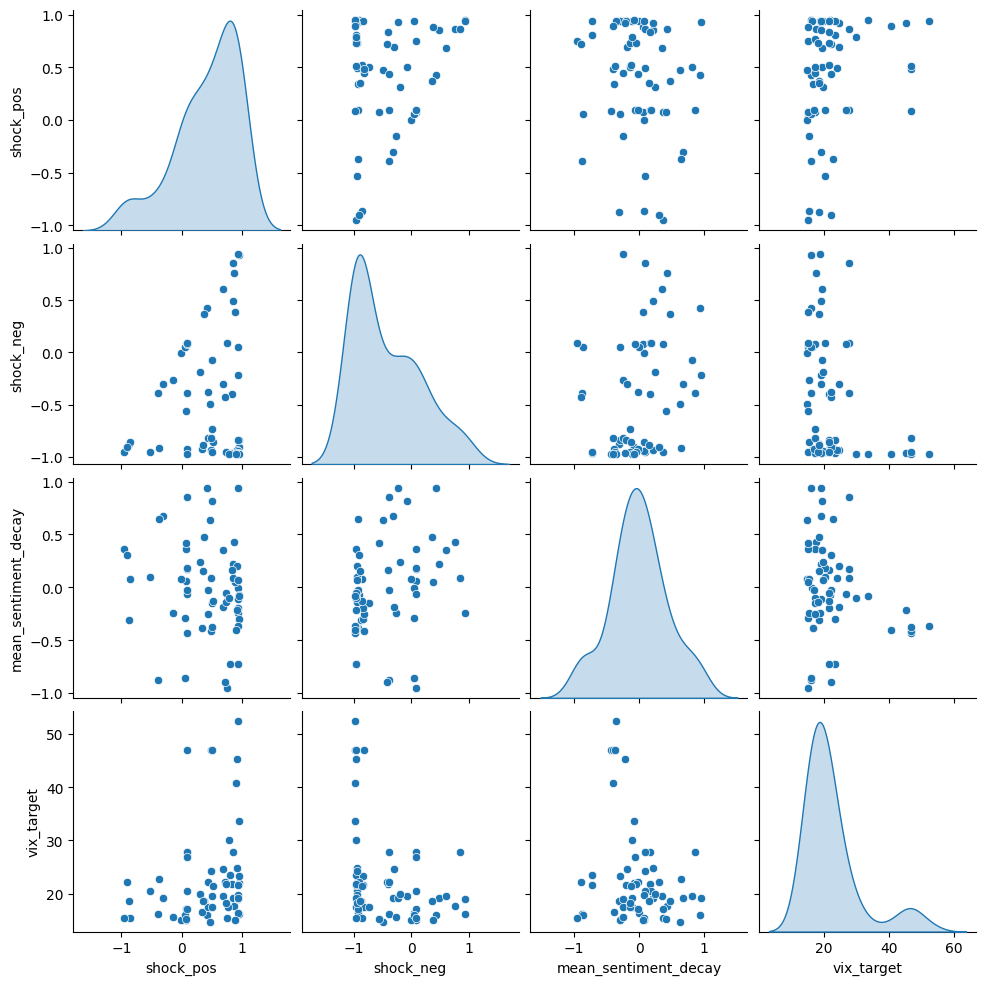

In [176]:
import seaborn as sns
sns.pairplot(df, vars=['shock_pos', 'shock_neg', 'mean_sentiment_decay', 'vix_target'], diag_kind='kde')


In [177]:
feature_sets = [ #for testing, winner was the first one, decreasing in quality for this model sequentially
    ['shock_neg', 'dominance_trigger'],
    ['shock_neg', 'sentiment_dominance'],
    ['shock_neg', 'sentiment_dominance', 'overall_min'],
    ['shock_pos', 'shock_neg', 'sentiment_dominance', 'overall_min'],
    ['shock_pos', 'shock_neg', 'mean_sentiment_decay', 'overall_min', 'sentiment_dominance']
]


In [220]:

df_model = df.dropna(subset=feature_sets[0] + ['vix_target']).copy() #i chose first set.
X = df_model[feature_sets[0]]
y = df_model['vix_target']

model = MarkovRegression(y, exog=X, k_regimes=2, switching_variance=False)
results = model.fit(disp=False)
print(f"Features: {feature_sets[0]}")
print(f"AIC: {results.aic:.3f}, LogL: {results.llf:.3f}")
print(results.summary().tables[0])
print("-" * 80)


Features: ['shock_neg', 'dominance_trigger']
AIC: 385.328, LogL: -183.664
                        Markov Switching Model Results                        
Dep. Variable:             vix_target   No. Observations:                   64
Model:               MarkovRegression   Log Likelihood                -183.664
Date:                Fri, 11 Apr 2025   AIC                            385.328
Time:                        13:51:17   BIC                            404.758
Sample:                             0   HQIC                           392.983
                                 - 64                                         
Covariance Type:               approx                                         
--------------------------------------------------------------------------------


In [221]:
# Get the most likely regime at each time step
df_model['regime_t'] = results.smoothed_marginal_probabilities[1].apply(lambda p: 1 if p >= 0.5 else 0)
selected_features = feature_sets[0]


In [225]:
df_model['vix_target_t+1'] = df_model['vix_target'].shift(-1) #lag for predicting the vix level, not the regime prediction

regime_col = df_model['regime_t'].copy() #so that it doesnt erase

df_model = df_model.dropna(subset=selected_features + ['vix_target_t+1']).copy()

df_model['regime_t'] = regime_col.loc[df_model.index]


X = df_model[selected_features]
y = df_model['vix_target_t+1']

model = MarkovRegression(
    endog=y,
    exog=X,
    k_regimes=2,
    switching_variance=False
)
results = model.fit() #model for predicting the vix level t+1


In [226]:
print(results.summary())



                        Markov Switching Model Results                        
Dep. Variable:         vix_target_t+1   No. Observations:                   63
Model:               MarkovRegression   Log Likelihood                -179.542
Date:                Fri, 11 Apr 2025   AIC                            377.085
Time:                        13:51:47   BIC                            396.373
Sample:                             0   HQIC                           384.671
                                 - 63                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.5193      0.604     32.328      0.000      18.336      20.703
x1            -0.8409      0.886     -0.949      0.3

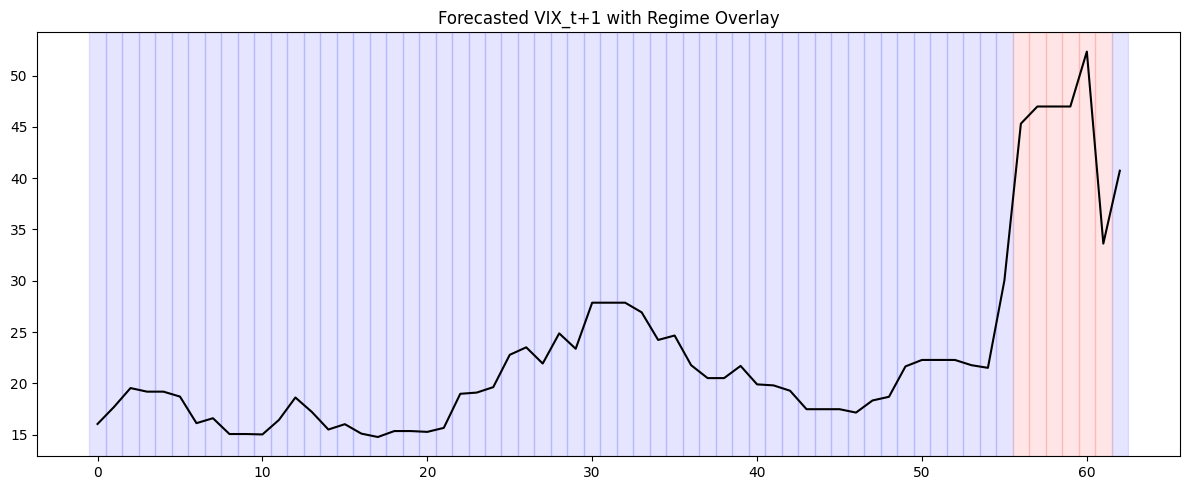

In [231]:
import matplotlib.pyplot as plt #graph vix t+1 with regime overlay

df_model['regime_t+1'] = df_model['regime_t'].shift(-1) #regime dataset for t+1

plt.figure(figsize=(12, 5))
plt.plot(df_model.index, df_model['vix_target_t+1'], label='VIX_t+1', color='black')

for i in range(len(df_model)):
    color = 'red' if df_model['regime_t+1'].iloc[i] == 1 else 'blue'
    plt.axvspan(df_model.index[i] - 0.5, df_model.index[i] + 0.5, color=color, alpha=0.1)

plt.title('Forecasted VIX_t+1 with Regime Overlay')
plt.tight_layout()
plt.show()


In [232]:
df_model['regime_t'] = results.smoothed_marginal_probabilities[1].apply(lambda p: 1 if p >= 0.5 else 0) #regime dataset for t


In [233]:
df_model['regime_t+1'] = df_model['regime_t'].shift(-1) #regime dataset for t+1


In [234]:
classification_df = df_model.dropna(subset=selected_features + ['regime_t+1']).copy() #classification dataset for t+1, for telling if regime is panic or not
X_cls = classification_df[selected_features]
y_cls = classification_df['regime_t+1']


In [241]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

clf = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=42)
clf.fit(X_cls, y_cls)

# Evaluate
y_pred = clf.predict(X_cls)
print(classification_report(y_cls, y_pred))


              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99        55
         1.0       1.00      0.86      0.92         7

    accuracy                           0.98        62
   macro avg       0.99      0.93      0.96        62
weighted avg       0.98      0.98      0.98        62



In [242]:
probs = clf.predict_proba(X_cls)[:, 1]
classification_df['panic_prob'] = probs


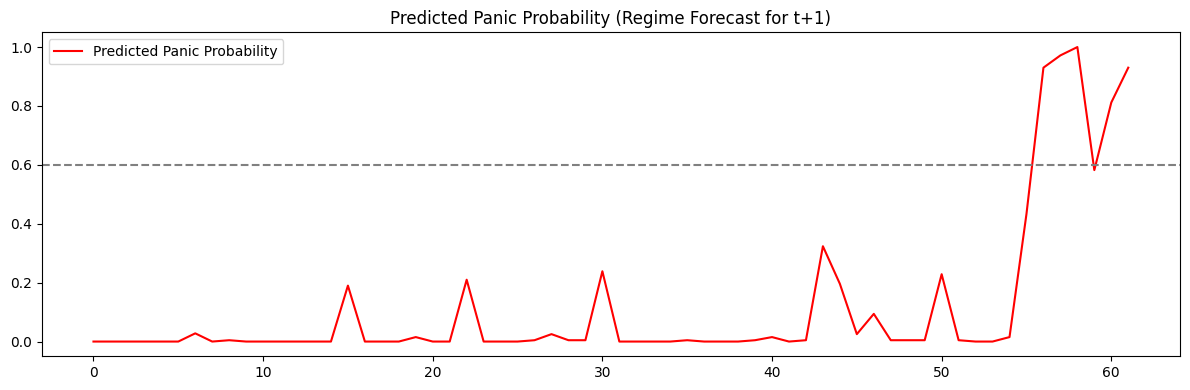

In [253]:
plt.figure(figsize=(12, 4))
plt.plot(classification_df.index, classification_df['panic_prob'], label='Predicted Panic Probability', color='red')
plt.axhline(0.6, linestyle='--', color='gray')
plt.title("Predicted Panic Probability (Regime Forecast for t+1)")
plt.legend()
plt.tight_layout()
plt.show()


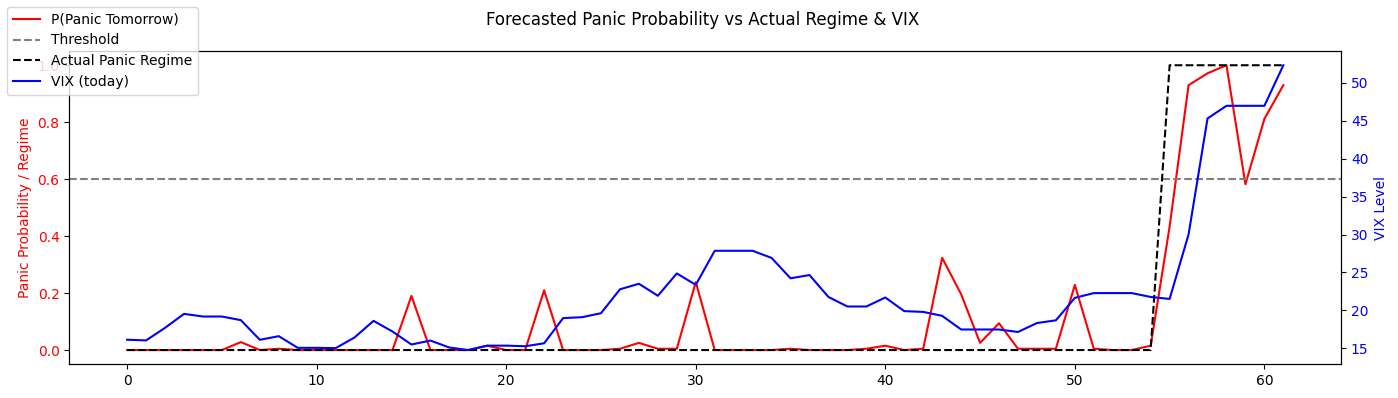

In [252]:
fig, ax1 = plt.subplots(figsize=(14, 4)) #GOLD. panic regime probability goes up before vix even spikes. probability of panic tomorrow from classifier is high.

# Panic probability
ax1.plot(classification_df.index, classification_df['panic_prob'], label='P(Panic Tomorrow)', color='red')
ax1.axhline(0.6, linestyle='--', color='gray', label='Threshold')
ax1.plot(classification_df.index, classification_df['regime_t+1'], linestyle='--', color='black', label='Actual Panic Regime')
ax1.set_ylabel("Panic Probability / Regime", color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Add second y-axis for VIX
ax2 = ax1.twinx()
ax2.plot(classification_df.index, classification_df['vix_target'], label='VIX (today)', color='blue')
ax2.set_ylabel("VIX Level", color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

fig.suptitle("Forecasted Panic Probability vs Actual Regime & VIX")
fig.tight_layout()
fig.legend(loc='upper left')
plt.show()


In [249]:
import numpy as np

# Detect spikes in panic probability
prob_spike = np.append([0], np.diff(probs)) > 0.3  # threshold adjustable

# Detect regime switches
delta_regime = np.diff(classification_df['regime_t+1'].values, prepend=classification_df['regime_t+1'].values[0])
regime_switch = delta_regime == 1   # calm → panic only


# Signal: spike + regime shift
signal = prob_spike & regime_switch
classification_df['signal'] = signal


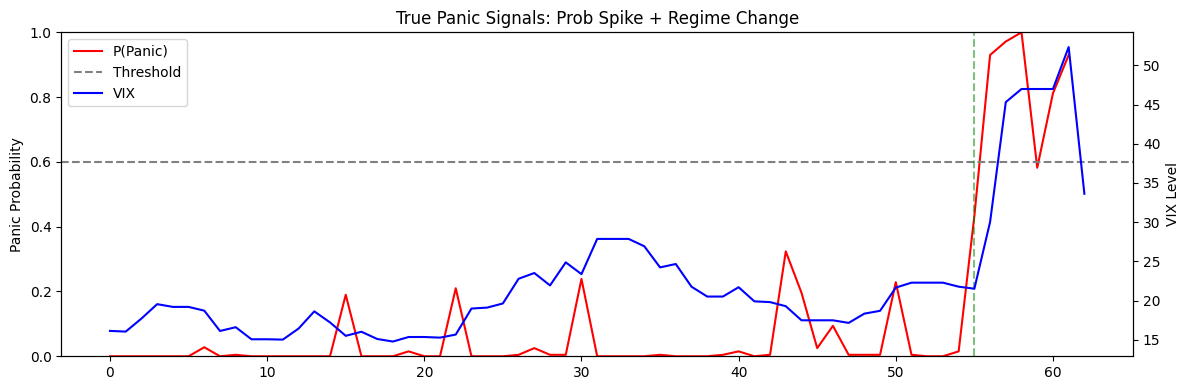

In [251]:
fig, ax1 = plt.subplots(figsize=(12, 4))

# Left Y-axis: Panic Probability
ax1.plot(probs, label='P(Panic)', color='red')
ax1.axhline(0.6, linestyle='--', color='gray', label='Threshold')
ax1.set_ylabel('Panic Probability')
ax1.set_ylim(0, 1)

# Right Y-axis: VIX
ax2 = ax1.twinx()
ax2.plot(df_model['vix_target'].values, label='VIX', color='blue')
ax2.set_ylabel('VIX Level')

# Signal lines
for i, val in enumerate(classification_df['signal']):
    if val:
        ax1.axvline(i, color='green', linestyle='--', alpha=0.5)

# Legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.title('True Panic Signals: Prob Spike + Regime Change')
plt.tight_layout()
plt.show()


# New Part, forecast

In [156]:
calm_df = df_model[df_model['regime_t'] == 0]['shock_neg']
panic_df = df_model[df_model['regime_t'] == 1]['shock_neg']

In [162]:
df_model.head()

,date,summary_mean,summary_min,summary_max,summary_pos_count,summary_neg_count,headline_mean,headline_min,headline_max,headline_pos_count,...,shock_neg,vix_predicted,decay,vix_return,sentiment_dominance,dominance_trigger,vix_target_t+1,regime,regime_t,regime_t+1
2,2025-02-18,0.372378,0.088780,0.655976,2,0,0.458808,0.083352,0.834263,2,...,0.086066,24.378713,-0.952138,NaN,2,0,15.270000,0,0,0.0
3,2025-02-19,-0.213531,-0.489639,0.062578,1,1,-0.276637,-0.639422,0.086147,1,...,-0.564530,20.307465,0.415593,-0.005212,0,0,15.660000,0,0,0.0
4,2025-02-20,-0.578604,-0.603541,-0.387781,0,12,0.083128,0.082524,0.086147,12,...,-0.260508,15.969919,-0.245084,0.025540,-12,1,18.980000,0,0,0.0
5,2025-02-24,0.944007,0.944007,0.944007,1,0,0.940079,0.940079,0.940079,1,...,0.942043,16.922705,-0.247738,0.212005,1,0,19.100000,0,0,0.0
6,2025-02-26,-0.017289,-0.942356,0.907779,1,1,0.722594,0.500550,0.944638,2,...,-0.220903,23.137939,0.942043,0.006322,0,0,19.629999,0,0,0.0


In [154]:
from statsmodels.tsa.ar_model import AutoReg #change lags when more data is available

model_calm = AutoReg(calm_df, lags=1).fit()
model_panic = AutoReg(panic_df, lags=1).fit()

/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


In [164]:
regime_today = df_model['regime_t'].iloc[-1]
model = model_panic if regime_today == 1 else model_calm

In [169]:
shock_forecast = []
history = [df_model['shock_neg'].dropna().iloc[-1]]  # Corrected here

for _ in range(5):
    next_val = model.predict(start=len(history), end=len(history)).iloc[0]

    shock_forecast.append(next_val)
    history.append(next_val)


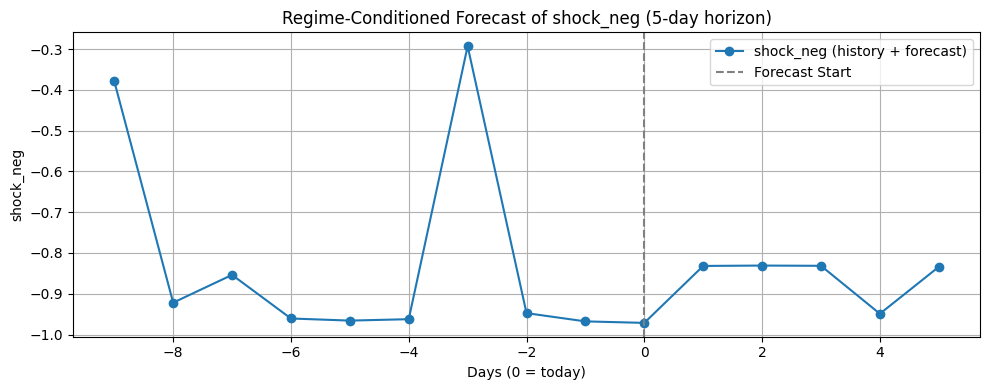

In [170]:
import matplotlib.pyplot as plt

n_history = 10
actual = df_model['shock_neg'].dropna().iloc[-n_history:].tolist()
combined = actual + shock_forecast
x = list(range(-n_history + 1, len(shock_forecast) + 1))

plt.figure(figsize=(10, 4))
plt.plot(x, combined, marker='o', label='shock_neg (history + forecast)')
plt.axvline(0, linestyle='--', color='gray', label='Forecast Start')
plt.title('Regime-Conditioned Forecast of shock_neg (5-day horizon)')
plt.xlabel('Days (0 = today)')
plt.ylabel('shock_neg')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
